# Homework 1: Supervised Deep Learning
##Neural networks for regression and classification 


##Select device

In [ ]:
#info about gpu
!nvidia-smi

Mon Apr 19 09:04:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   7552MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
cpu_default = False

global device
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
device_cpu = torch.device("cpu")

if cpu_default: device=device_cpu
print('Selected device:',device)

Selected device: cuda


## Import Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,confusion_matrix
from tqdm.auto import tqdm
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

##Work folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab Notebooks/Neural Networks and Deep Learning/Homework1'
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Neural Networks and Deep Learning/Homework1


#Regression task

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

##Data

In [ ]:
try:
  train_df = pd.read_csv('regression_dataset/train_data.csv',dtype='float32')
  test_df = pd.read_csv('regression_dataset/test_data.csv',dtype='float32')
except:
  !wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
  !wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
  train_df = pd.read_csv('regression_dataset/train_data.csv',dtype='float32')
  test_df = pd.read_csv('regression_dataset/test_data.csv',dtype='float32')

print(f'the training samples are {len(train_df)} and the test ones are {len(test_df)}')

the training samples are 100 and the test ones are 100


### Cross Validation Division


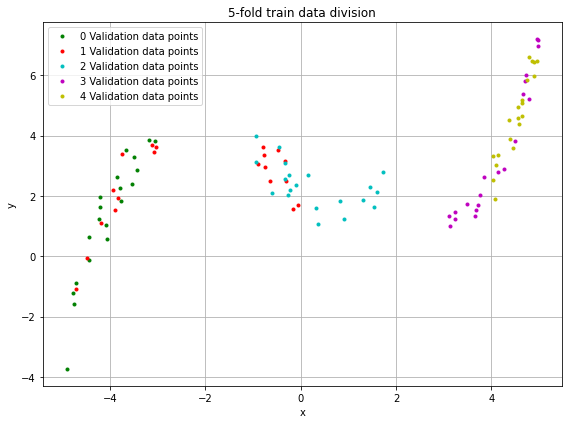

In [ ]:
k=5
shuffle=False
kf_indices=pd.DataFrame(KFold(n_splits=k,shuffle=shuffle).split(train_df),columns=['train_indices','valid_indices'])

plt.close('all')
plt.figure(figsize=(8,6))
colors='b','g','r','c','m','y','k'
plt.title('{}-fold train data division'.format(k))
for i,valid_index in enumerate(kf_indices['valid_indices']):
  plt.plot(train_df.iloc[valid_index,0], train_df.iloc[valid_index,1], color=f'{colors[(i+1)%len(colors)]}', ls='', marker='.', label=f'{i} Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

###Dataset visualization


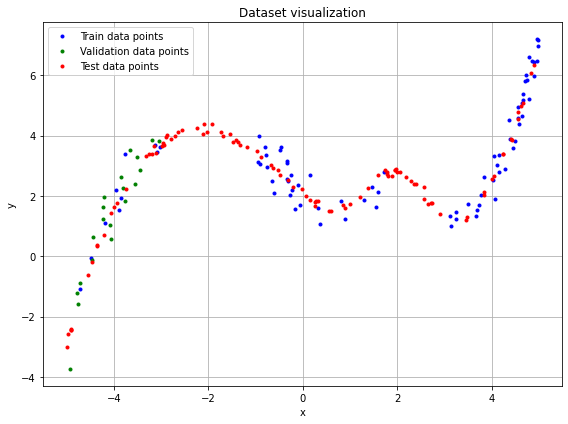

In [ ]:
train_data_example=train_df.iloc[kf_indices['train_indices'][0]]
valid_data_example=train_df.iloc[kf_indices['valid_indices'][0]]
plt.close('all')
plt.figure(figsize=(8,6))
plt.title('Dataset visualization')
plt.plot(train_data_example['input'],train_data_example['label'], color='b', ls='', marker='.', label='Train data points')
plt.plot(valid_data_example['input'],valid_data_example['label'], color='g', ls='', marker='.', label='Validation data points')
plt.plot(test_df['input'], test_df['label'], color='r', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

##Activation Functions



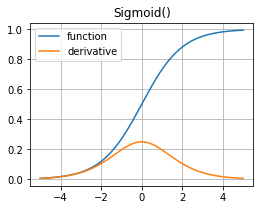

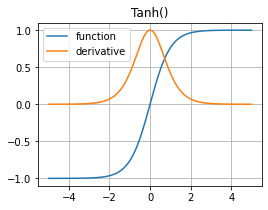

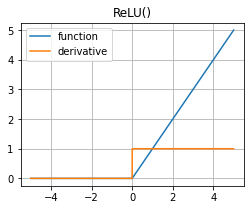

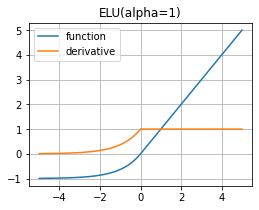

In [ ]:
sigmoid=nn.Sigmoid()
sigmoid_der = lambda x: sigmoid(x) * (1 - sigmoid(x))

tanh=nn.Tanh()
tanh_der = lambda x: 1 - tanh(x)**2

ReLU = nn.ReLU()
ReLU_der = lambda x: ReLU(x)>0

alpha=1
ELU = nn.ELU(alpha=alpha)
ELU_der = lambda x: (x>0) + alpha*np.exp(x)*(x<=0)

activations = [sigmoid, tanh, ReLU, ELU]
activations_der = [sigmoid_der, tanh_der, ReLU_der, ELU_der]

x_plot = torch.tensor(np.linspace(-5,5,1000))

plt.close('all')
for act,act_der in zip(activations,activations_der):
  plt.figure(figsize=(4,3))
  plt.title(act)
  plt.plot(x_plot, act(x_plot),label='function')
  plt.plot(x_plot, act_der(x_plot),label='derivative')
  plt.legend()
  plt.grid()
  plt.show()

##Network Class

In [ ]:
class Regression_Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, act = nn.Sigmoid()):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = act
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

##Model validation with cross validation

### Training

In [ ]:
#Parameters
#activations
learning_rates=[1e-1,1e-2,1e-3]
loss_fn = nn.MSELoss()
opt=optim.Adam
Nh1s = [64,128]
Nh2s = [64,128,256]
num_epochs = 1000

log_dataset={}
for act in activations:
  for lr in learning_rates:
    for Nh1 in Nh1s:
      for Nh2 in Nh2s:
        net_name=f'Net_act_{str(act)[:3]}_lr_{lr}_nh1_{Nh1}_nh2_{Nh2}'
        print('----------------------------------')
        print(net_name)
        print('----------------------------------')

        path='regression_validation_models/'+net_name
        os.makedirs(path,exist_ok=True)

        for i,(train_index,valid_index) in enumerate(kf_indices.values):
          print()
          print(f'{i}-th Validation model')
          print()
          train_dataloader= DataLoader(np.array(train_df.iloc[train_index]), batch_size=4, shuffle=True, num_workers=0)
          val_dataloader  = DataLoader(np.array(train_df.iloc[valid_index]), batch_size=len(train_df.iloc[valid_index]), shuffle=False, num_workers=0)
          
          # Initialize the network
          net = Regression_Net(1, Nh1, Nh2, 1, act=act)
          net.to(device)
          # Update the network parameters
          try:
            net_state_dict=torch.load(os.path.join(path,f'valid_net_par_{i}.torch'),map_location=torch.device(dev))
            net.load_state_dict(net_state_dict)
            try:
              log_dataset[net_name]
            except:
              log_dataset[net_name]=pd.read_csv(os.path.join(path,f'valid_net_train_err_{i}.csv'))
            log_dataset[net_name][f'train_error_{i}']=pd.read_csv(os.path.join(path,f'valid_net_train_err_{i}.csv'))
            log_dataset[net_name][f'valid_error_{i}']=pd.read_csv(os.path.join(path,f'valid_net_valid_err_{i}.csv'))
            continue 
          except:
            pass
         
          # Define the optimizer
          optimizer = opt(net.parameters(), lr=lr)
          ### TRAINING LOOP
          train_loss_log = []
          val_loss_log = []
          for epoch_num in range(num_epochs):
            print(f'EPOCH {epoch_num}')

            ### TRAIN
            train_loss= []
            net.train() # Training mode (e.g. enable dropout)
            for sample_batched in train_dataloader:
              # Move data to device
              x_batch = sample_batched[:,0].unsqueeze(1).to(device)
              label_batch = sample_batched[:,1].unsqueeze(1).to(device)

              # Forward pass
              out = net(x_batch)

              # Compute loss
              loss = loss_fn(out, label_batch)

              # Backpropagation
              net.zero_grad()
              loss.backward()

              # Update the weights
              optimizer.step()

              # Save train loss for this batch
              loss_batch = loss.detach().cpu().numpy()
              train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
            print(f"\tAVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)

            ### VALIDATION
            val_loss= []
            net.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # Disable gradient tracking
              for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[:,0].unsqueeze(1).to(device)
                label_batch = sample_batched[:,1].unsqueeze(1).to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

              # Save average validation loss
              val_loss = np.mean(val_loss)
              print(f"\tAVERAGE VAL LOSS: {np.mean(val_loss)}")
              val_loss_log.append(val_loss)

          try:
            log_dataset[net_name]
          except:
            log_dataset[net_name]=pd.DataFrame()
          log_dataset[net_name][f'train_error_{i}']=train_loss_log
          log_dataset[net_name][f'valid_error_{i}']=val_loss_log
          log_dataset[net_name][f'train_error_{i}'].to_csv(os.path.join(path,f'valid_net_train_err_{i}.csv'),index=False)
          log_dataset[net_name][f'valid_error_{i}'].to_csv(os.path.join(path,f'valid_net_valid_err_{i}.csv'),index=False)
          net_state_dict = net.state_dict()
          torch.save(net_state_dict, os.path.join(path,f'valid_net_par_{i}.torch'))



----------------------------------
Net_act_Sig_lr_0.1_nh1_64_nh2_64
----------------------------------

0-th Validation model


1-th Validation model


2-th Validation model


3-th Validation model


4-th Validation model

----------------------------------
Net_act_Sig_lr_0.1_nh1_64_nh2_128
----------------------------------

0-th Validation model


1-th Validation model


2-th Validation model


3-th Validation model


4-th Validation model

----------------------------------
Net_act_Sig_lr_0.1_nh1_64_nh2_256
----------------------------------

0-th Validation model


1-th Validation model


2-th Validation model


3-th Validation model


4-th Validation model

----------------------------------
Net_act_Sig_lr_0.1_nh1_128_nh2_64
----------------------------------

0-th Validation model


1-th Validation model


2-th Validation model


3-th Validation model


4-th Validation model

----------------------------------
Net_act_Sig_lr_0.1_nh1_128_nh2_128
----------------------------------


### Mean error history

In [ ]:
model_performances=[]
for act in activations:
  for lr in learning_rates:
    for Nh1 in Nh1s:
      for Nh2 in Nh2s:
        net_name=f'Net_act_{str(act)[:3]}_lr_{lr}_nh1_{Nh1}_nh2_{Nh2}'
        average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
        average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
        smoothing_window=20        
        smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
        smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
        plt.figure(figsize=(8,6))
        plt.title(net_name+' Average loss')
        plt.semilogy(smoothed_train_loss, label='Train loss')
        plt.semilogy(smoothed_valid_loss, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()
        model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min(),smoothed_valid_loss.argmin()])


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_results=pd.DataFrame(model_performances,columns=['Model Name','Min Train Loss','Min Valid Loss','Epoch Min Valid Loss'])
model_results_sorted=model_results.sort_values('Min Valid Loss')

#Exclude bad trained models
model_results_sorted=model_results_sorted[model_results_sorted['Epoch Min Valid Loss']>(num_epochs//3)] 

model_results_sorted

,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
12,Net_act_Sig_lr_0.001_nh1_64_nh2_64,0.257724,0.385020,961
15,Net_act_Sig_lr_0.001_nh1_128_nh2_64,0.242985,0.389062,508
16,Net_act_Sig_lr_0.001_nh1_128_nh2_128,0.249857,0.418479,589
17,Net_act_Sig_lr_0.001_nh1_128_nh2_256,0.255255,0.422797,995
33,Net_act_Tan_lr_0.001_nh1_128_nh2_64,0.205909,0.427056,999
34,Net_act_Tan_lr_0.001_nh1_128_nh2_128,0.196090,0.443086,848
35,Net_act_Tan_lr_0.001_nh1_128_nh2_256,0.199005,0.446844,997
44,Net_act_ReL_lr_0.01_nh1_64_nh2_256,0.238146,0.464241,959
32,Net_act_Tan_lr_0.001_nh1_64_nh2_256,0.227073,0.466187,931
30,Net_act_Tan_lr_0.001_nh1_64_nh2_64,0.210940,0.472631,479


##Hyperparameters comparison

### Learning rates comparison

In [ ]:
n_samples=6
print('0.1 Learning Rate')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('lr_0.1_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('0.01 Learning Rate')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('lr_0.01_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('0.001 Learning Rate')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('lr_0.001_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

0.1 Learning Rate


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
0,Net_act_Sig_lr_0.1_nh1_64_nh2_64,2.736694,3.899283,342
21,Net_act_Tan_lr_0.1_nh1_128_nh2_64,4.574258,4.459744,927
5,Net_act_Sig_lr_0.1_nh1_128_nh2_256,3.996248,4.485080,441
19,Net_act_Tan_lr_0.1_nh1_64_nh2_128,5.716904,6.021422,839
20,Net_act_Tan_lr_0.1_nh1_64_nh2_256,8.162722,7.173073,740


Mean Validation Error:  5.207720075368878

0.01 Learning Rate


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
44,Net_act_ReL_lr_0.01_nh1_64_nh2_256,0.238146,0.464241,959
7,Net_act_Sig_lr_0.01_nh1_64_nh2_128,0.277386,0.481868,479
43,Net_act_ReL_lr_0.01_nh1_64_nh2_128,0.255537,0.496018,883
64,Net_act_ELU_lr_0.01_nh1_128_nh2_128,0.410843,0.512440,707
6,Net_act_Sig_lr_0.01_nh1_64_nh2_64,0.280953,0.525408,508
65,Net_act_ELU_lr_0.01_nh1_128_nh2_256,0.481822,0.529533,586


Mean Validation Error:  0.501584480827053

0.001 Learning Rate


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
12,Net_act_Sig_lr_0.001_nh1_64_nh2_64,0.257724,0.385020,961
15,Net_act_Sig_lr_0.001_nh1_128_nh2_64,0.242985,0.389062,508
16,Net_act_Sig_lr_0.001_nh1_128_nh2_128,0.249857,0.418479,589
17,Net_act_Sig_lr_0.001_nh1_128_nh2_256,0.255255,0.422797,995
33,Net_act_Tan_lr_0.001_nh1_128_nh2_64,0.205909,0.427056,999
34,Net_act_Tan_lr_0.001_nh1_128_nh2_128,0.196090,0.443086,848


Mean Validation Error:  0.4142499507406754



### Activation functions comparison

In [ ]:
n_samples=6
print('Sigmoid')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('Sig_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('Tanh')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('Tan_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('ReLU')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('ReL_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('ELU')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('ELU_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

Sigmoid


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
12,Net_act_Sig_lr_0.001_nh1_64_nh2_64,0.257724,0.385020,961
15,Net_act_Sig_lr_0.001_nh1_128_nh2_64,0.242985,0.389062,508
16,Net_act_Sig_lr_0.001_nh1_128_nh2_128,0.249857,0.418479,589
17,Net_act_Sig_lr_0.001_nh1_128_nh2_256,0.255255,0.422797,995
7,Net_act_Sig_lr_0.01_nh1_64_nh2_128,0.277386,0.481868,479
6,Net_act_Sig_lr_0.01_nh1_64_nh2_64,0.280953,0.525408,508


Mean Validation Error:  0.4371055819011402

Tanh


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
33,Net_act_Tan_lr_0.001_nh1_128_nh2_64,0.205909,0.427056,999
34,Net_act_Tan_lr_0.001_nh1_128_nh2_128,0.196090,0.443086,848
35,Net_act_Tan_lr_0.001_nh1_128_nh2_256,0.199005,0.446844,997
32,Net_act_Tan_lr_0.001_nh1_64_nh2_256,0.227073,0.466187,931
30,Net_act_Tan_lr_0.001_nh1_64_nh2_64,0.210940,0.472631,479
24,Net_act_Tan_lr_0.01_nh1_64_nh2_64,0.353676,0.571884,822


Mean Validation Error:  0.47128131668380835

ReLU


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
44,Net_act_ReL_lr_0.01_nh1_64_nh2_256,0.238146,0.464241,959
43,Net_act_ReL_lr_0.01_nh1_64_nh2_128,0.255537,0.496018,883
42,Net_act_ReL_lr_0.01_nh1_64_nh2_64,0.251178,0.565088,826
51,Net_act_ReL_lr_0.001_nh1_128_nh2_64,0.223731,0.664863,916
47,Net_act_ReL_lr_0.01_nh1_128_nh2_256,0.272864,0.673091,871
50,Net_act_ReL_lr_0.001_nh1_64_nh2_256,0.220951,0.686409,959


Mean Validation Error:  0.5916182154665394

ELU


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
67,Net_act_ELU_lr_0.001_nh1_64_nh2_128,0.265105,0.474842,954
70,Net_act_ELU_lr_0.001_nh1_128_nh2_128,0.253127,0.503530,963
64,Net_act_ELU_lr_0.01_nh1_128_nh2_128,0.410843,0.512440,707
71,Net_act_ELU_lr_0.001_nh1_128_nh2_256,0.262740,0.529288,746
65,Net_act_ELU_lr_0.01_nh1_128_nh2_256,0.481822,0.529533,586
68,Net_act_ELU_lr_0.001_nh1_64_nh2_256,0.267558,0.538973,996


Mean Validation Error:  0.5147676019370558



### Number of first hidden units

In [ ]:
n_samples=6
print('64 first hidden units')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('nh1_64_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

print('128 first hidden units')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('nh1_128_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), end='\n\n')

64 first hidden units


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
12,Net_act_Sig_lr_0.001_nh1_64_nh2_64,0.257724,0.385020,961
44,Net_act_ReL_lr_0.01_nh1_64_nh2_256,0.238146,0.464241,959
32,Net_act_Tan_lr_0.001_nh1_64_nh2_256,0.227073,0.466187,931
30,Net_act_Tan_lr_0.001_nh1_64_nh2_64,0.210940,0.472631,479
67,Net_act_ELU_lr_0.001_nh1_64_nh2_128,0.265105,0.474842,954
7,Net_act_Sig_lr_0.01_nh1_64_nh2_128,0.277386,0.481868,479


Mean Validation Error:  0.4574648568779238

128 first hidden units


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
15,Net_act_Sig_lr_0.001_nh1_128_nh2_64,0.242985,0.389062,508
16,Net_act_Sig_lr_0.001_nh1_128_nh2_128,0.249857,0.418479,589
17,Net_act_Sig_lr_0.001_nh1_128_nh2_256,0.255255,0.422797,995
33,Net_act_Tan_lr_0.001_nh1_128_nh2_64,0.205909,0.427056,999
34,Net_act_Tan_lr_0.001_nh1_128_nh2_128,0.196090,0.443086,848
35,Net_act_Tan_lr_0.001_nh1_128_nh2_256,0.199005,0.446844,997


Mean Validation Error:  0.4245539150861761



##Selected Models

###Training

In [ ]:
print('Selected Models; best for each activation, middle, last:')
selected_models=model_results_sorted.iloc[[len(model_results_sorted)//2,-1]]
selected_models=selected_models.append(model_results_sorted[model_results_sorted['Model Name'].str.contains('Sig')].iloc[0])
selected_models=selected_models.append(model_results_sorted[model_results_sorted['Model Name'].str.contains('Tan')].iloc[0])
selected_models=selected_models.append(model_results_sorted[model_results_sorted['Model Name'].str.contains('ReL')].iloc[0])
selected_models=selected_models.append(model_results_sorted[model_results_sorted['Model Name'].str.contains('ELU')].iloc[0])
selected_models=selected_models.sort_values('Min Valid Loss')
selected_models

Selected Models; best for each activation, middle, last:


,Model Name,Min Train Loss,Min Valid Loss,Epoch Min Valid Loss
12,Net_act_Sig_lr_0.001_nh1_64_nh2_64,0.257724,0.385020,961
33,Net_act_Tan_lr_0.001_nh1_128_nh2_64,0.205909,0.427056,999
44,Net_act_ReL_lr_0.01_nh1_64_nh2_256,0.238146,0.464241,959
67,Net_act_ELU_lr_0.001_nh1_64_nh2_128,0.265105,0.474842,954
42,Net_act_ReL_lr_0.01_nh1_64_nh2_64,0.251178,0.565088,826
20,Net_act_Tan_lr_0.1_nh1_64_nh2_256,8.162722,7.173073,740


In [ ]:
log_dataset={}
nets=[]

train_dataloader= DataLoader(np.array(train_df), batch_size=4, shuffle=True, num_workers=0)

for i in range(len(selected_models)):
  torch.manual_seed(0)
  net_name=selected_models.iloc[i]['Model Name']
  #Parameters
  num_epochs=round(selected_models.iloc[i]['Epoch Min Valid Loss']/10)*10
  name_split=net_name.split(sep='_')
  if (name_split[2]==str(sigmoid)[:3]):
    act=sigmoid
  elif (name_split[2]==str(tanh)[:3]):
    act=tanh
  elif (name_split[2]==str(ReLU)[:3]):
    act=ReLU
  elif (name_split[2]==str(ELU)[:3]):
    act=ELU
  lr = float(name_split[4])
  Nh1 = int(name_split[6])
  Nh2 = int(name_split[8])

  loss_fn = nn.MSELoss()
  opt=optim.Adam

  print('----------------------------------')
  print(net_name)
  print('----------------------------------')

  path='regression_selected_models/'+net_name
  os.makedirs(path,exist_ok=True)

  # Initialize the network
  net = Regression_Net(1, Nh1, Nh2, 1, act=act)
  net.to(device)
  # Update the network parameters
  try:
    net_state_dict=torch.load(os.path.join(path,f'net_params.torch'),map_location=torch.device(dev))
    net.load_state_dict(net_state_dict)
    try:
      log_dataset[net_name]
    except:
      log_dataset[net_name]=pd.read_csv(os.path.join(path,f'net_train_err.csv'))
    log_dataset[net_name][f'train_error']=pd.read_csv(os.path.join(path,f'net_train_err.csv'))
    train=False 
  except:
    train=True

  # Define the optimizer
  optimizer = opt(net.parameters(), lr=lr)
  ### TRAINING LOOP
  train_loss_log = []
  if train:
    for epoch_num in range(num_epochs):
      print(f'EPOCH {epoch_num}')

      ### TRAIN
      train_loss= []
      net.train() # Training mode (e.g. enable dropout)
      for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[:,0].unsqueeze(1).to(device)
        label_batch = sample_batched[:,1].unsqueeze(1).to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

      # Save average train loss
      train_loss = np.mean(train_loss)
      print(f"\tAVERAGE TRAIN LOSS: {train_loss}")
      train_loss_log.append(train_loss)

    try:
      log_dataset[net_name]
    except:
      log_dataset[net_name]=pd.DataFrame()
    log_dataset[net_name][f'train_error']=train_loss_log
    log_dataset[net_name][f'train_error'].to_csv(os.path.join(path,f'net_train_err.csv'),index=False)
    net_state_dict = net.state_dict()
    torch.save(net_state_dict, os.path.join(path,f'net_params.torch'))

  nets.append((net_name,copy.deepcopy(net)))

----------------------------------
Net_act_Sig_lr_0.001_nh1_64_nh2_64
----------------------------------
----------------------------------
Net_act_Tan_lr_0.001_nh1_128_nh2_64
----------------------------------
----------------------------------
Net_act_ReL_lr_0.01_nh1_64_nh2_256
----------------------------------
----------------------------------
Net_act_ELU_lr_0.001_nh1_64_nh2_128
----------------------------------
----------------------------------
Net_act_ReL_lr_0.01_nh1_64_nh2_64
----------------------------------
----------------------------------
Net_act_Tan_lr_0.1_nh1_64_nh2_256
----------------------------------


### Error history

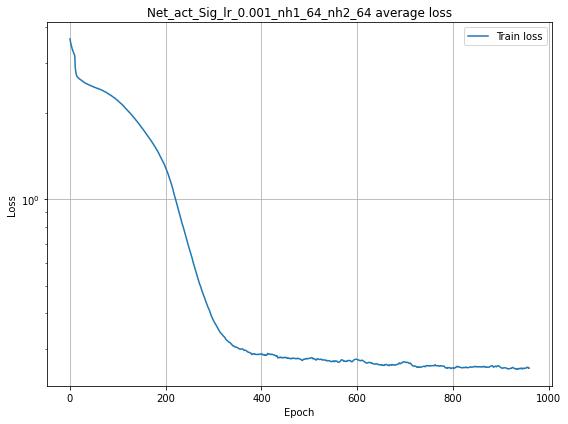

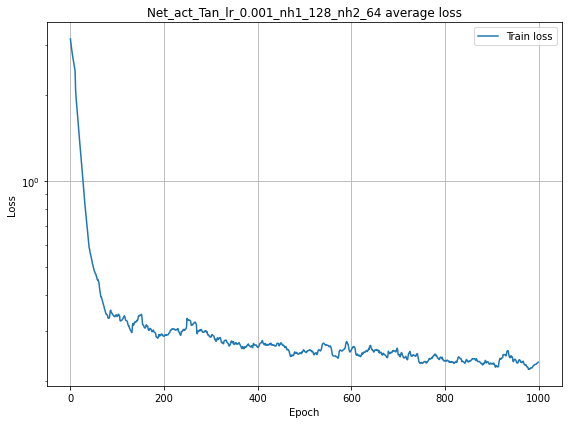

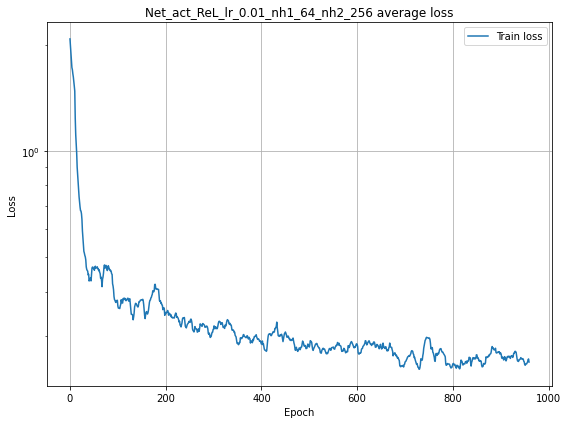

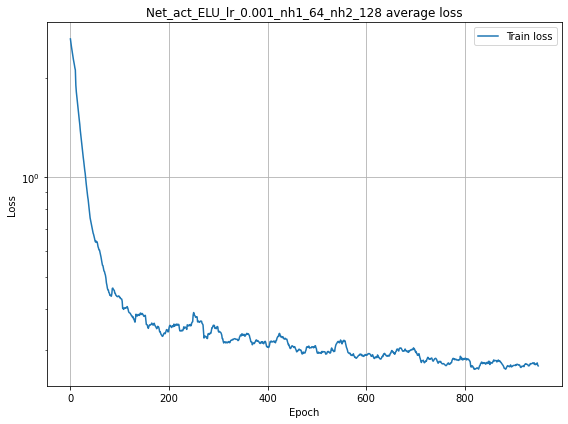

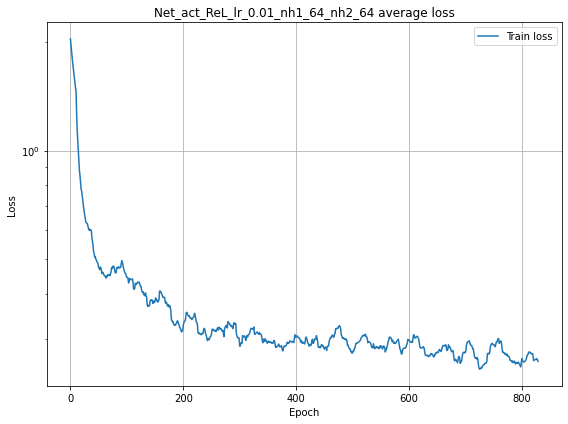

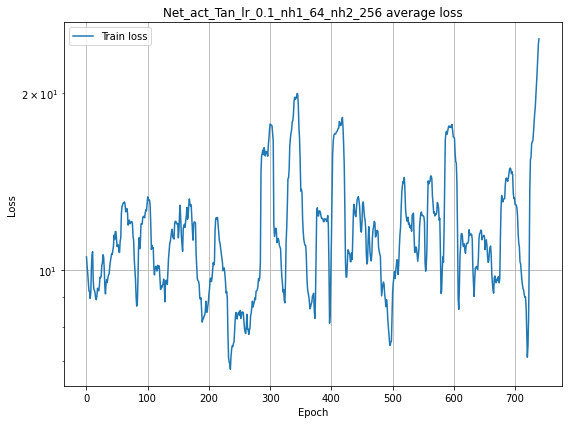

In [ ]:
for name,net in nets:
  net_name=name
  plt.figure(figsize=(8,6))
  plt.title(net_name+' Average loss')
  smoothing_window=21       
  smoothed_train_loss=log_dataset[net_name].rolling(smoothing_window, min_periods=1,center=True).mean()
  plt.semilogy(smoothed_train_loss, label='Train loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

### Outputs and test evaluation

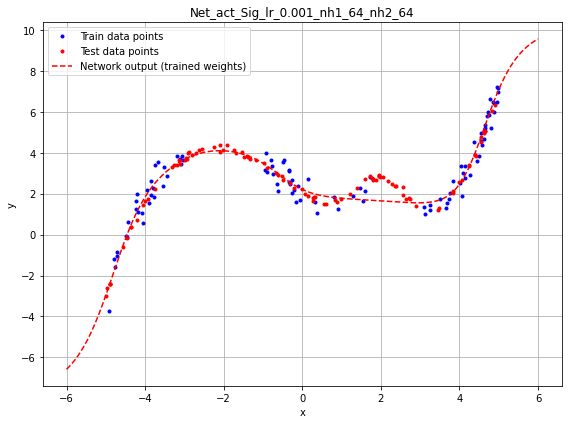

MSE Test Error:  0.20403685


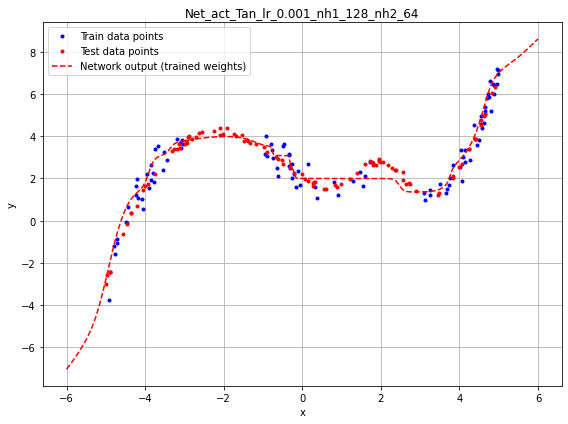

MSE Test Error:  0.17839663


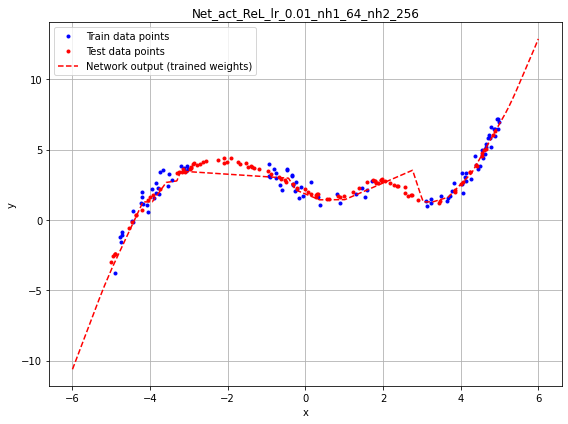

MSE Test Error:  0.31276256


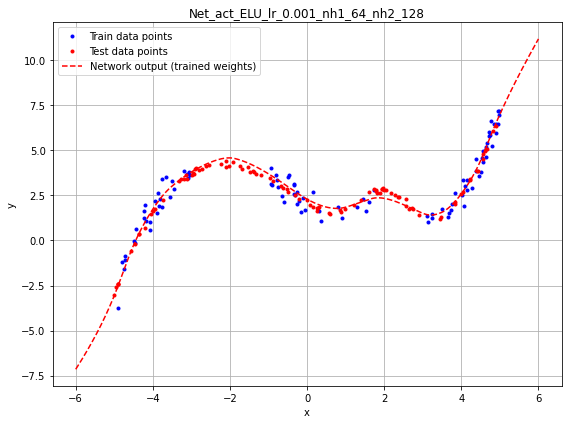

MSE Test Error:  0.06429256


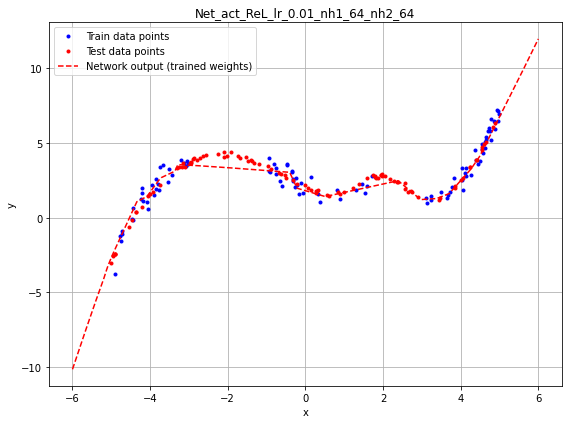

MSE Test Error:  0.16833769


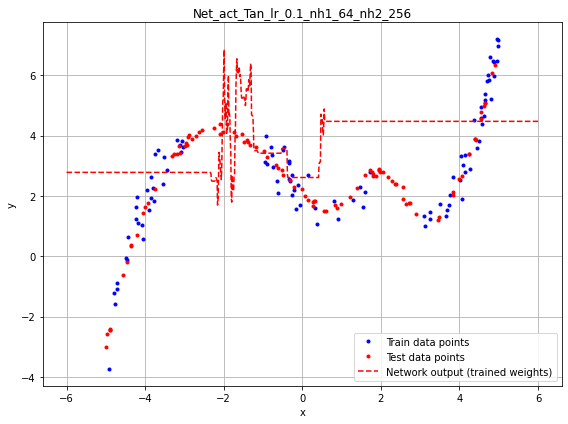

MSE Test Error:  4.2087464


In [ ]:
test_errors=[]
for name,net in nets:
  x_highres = torch.linspace(-6, 6, 1000).unsqueeze(1).to(device)
  test_tensor = torch.Tensor(test_df.iloc[:,0]).unsqueeze(1).to(device)

  net_output = net.forward(x_highres)
  net_prediction = net.forward(test_tensor).squeeze(1)
  
  x_highres = x_highres.cpu().detach().numpy()
  net_output = net_output.cpu().detach().numpy()
  net_prediction = net_prediction.cpu().detach().numpy()

  MSE=np.mean((np.array(test_df.iloc[:,1])-net_prediction)**2)

  ### Plot
  plt.close('all')
  plt.figure(figsize=(8,6))
  plt.title(name)
  plt.plot(train_df['input'], train_df['label'], color='b', ls='', marker='.', label='Train data points')
  plt.plot(test_df['input'], test_df['label'], color='r', ls='', marker='.', label='Test data points')
  plt.plot(x_highres, net_output, color='r', ls='--', label='Network output (trained weights)')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()
  print('MSE Test Error: ',MSE)
  test_errors.append([name,MSE])

### Analyze activations example

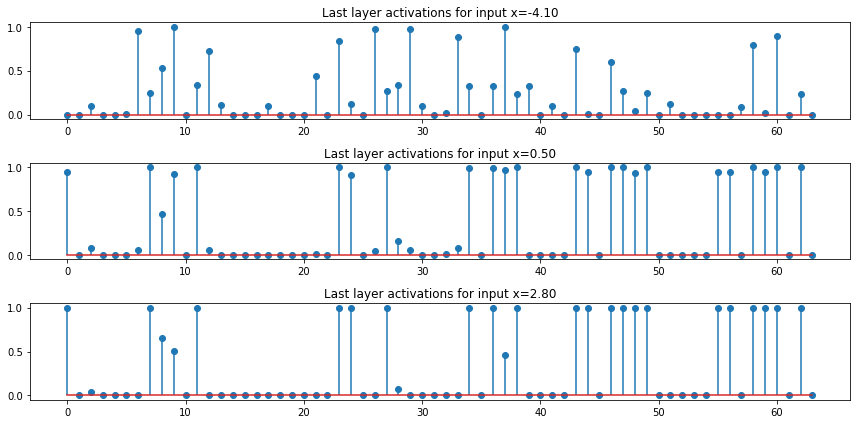

In [ ]:
net=nets[0][1]

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.5]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.8]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

## Augmented Dataset

### Creation and visualization

In [ ]:
train_df_sorted=train_df.sort_values('input')
N_new_points=200

window=5
centroids=pd.DataFrame(train_df_sorted.iloc[0]).T
for i in range(0,len(train_df_sorted),window):
  centroids=centroids.append(train_df_sorted.iloc[i:i+window].mean(axis=0),ignore_index=True)
centroids=centroids.append(train_df_sorted.iloc[-1])

new_points=centroids.sort_values('input')
for i in range(len(new_points),N_new_points):
  distances=np.sqrt(np.sum((np.array(new_points[0:-1])-np.array(new_points[1:]))**2,axis=1))
  max_dist=distances.max()
  max_dist_ind=distances.argmax()
  #select the 2 points around the maximum distance
  points=new_points.iloc[max_dist_ind:max_dist_ind+2]
  #create new point by random weight average   
  weights=np.random.random(size=len(points))
  weights=weights/weights.sum() #make weight sum = 1
  new_point=((points.T*weights).T).sum(axis=0)
  new_points=new_points.append(new_point,ignore_index=True)
  new_points=new_points.sort_values('input')

#Add gaussian and uniform noise to new generated points
noise=np.random.normal(scale=0.2,size=new_points.shape)
new_points=new_points+noise
noise=np.random.uniform(low=-0.1,high=0.1,size=new_points.shape)
new_points=new_points+noise
#Add original dataset with gaussian noise
noise=np.random.normal(scale=0.2,size=train_df.shape)
train_df_noise=train_df+noise
#Add original dataset with uniform noise
noise=np.random.uniform(low=-0.1,high=0.1,size=train_df.shape)
train_df_noise=train_df_noise.append(train_df+noise)
augmented_train_df=train_df.append(train_df_noise).append(new_points).astype(np.float32)

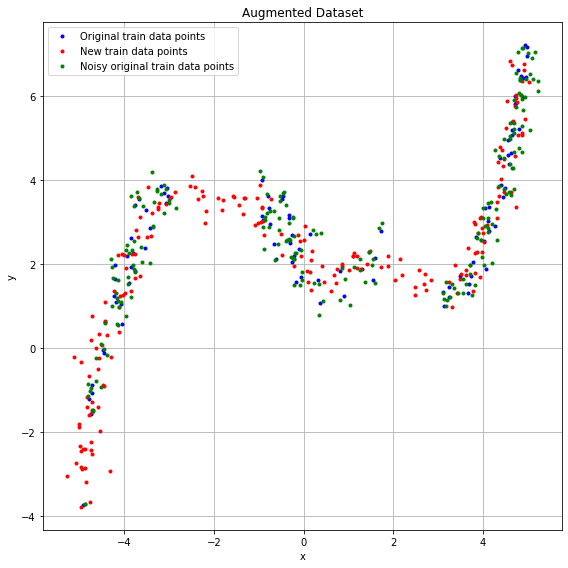

In [ ]:
plt.close('all')
plt.figure(figsize=(8,8))
plt.title('Augmented Dataset')
plt.plot(train_df['input'], train_df['label'], color='b', ls='', marker='.', label='Original train data points')
plt.plot(new_points['input'], new_points['label'], color='r', ls='', marker='.', label='New train data points')
plt.plot(train_df_noise['input'], train_df_noise['label'], color='g', ls='', marker='.', label='Noisy original train data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Train with augmented dataset

In [ ]:
train_dataloader= DataLoader(np.array(augmented_train_df), batch_size=4, shuffle=True, num_workers=0)

net_name='AugmentedData'+selected_models.iloc[0]['Model Name']
#Parameters
num_epochs=round(selected_models.iloc[0]['Epoch Min Valid Loss']/10)*10*len(train_df)//len(augmented_train_df)
name_split=net_name.split(sep='_')
if (name_split[2]==str(sigmoid)[:3]):
  act=sigmoid
elif (name_split[2]==str(tanh)[:3]):
  act=tanh
elif (name_split[2]==str(ReLU)[:3]):
  act=ReLU
elif (name_split[2]==str(ELU)[:3]):
  act=ELU
lr = float(name_split[4])
Nh1 = int(name_split[6])
Nh2 = int(name_split[8])

loss_fn = nn.MSELoss()
opt=optim.Adam

print('----------------------------------')
print(net_name)
print('----------------------------------')

path='regression_selected_models/'+net_name
os.makedirs(path,exist_ok=True)

# Initialize the network
net = Regression_Net(1, Nh1, Nh2, 1, act=act)
net.to(device)
# Update the network parameters
try:
  net_state_dict=torch.load(os.path.join(path,f'net_params.torch'),map_location=torch.device(dev))
  net.load_state_dict(net_state_dict)
  try:
    log_dataset[net_name]
  except:
    log_dataset[net_name]=pd.read_csv(os.path.join(path,f'net_train_err.csv'))
  log_dataset[net_name][f'train_error']=pd.read_csv(os.path.join(path,f'net_train_err.csv'))
  train=False 
except:
  train=True

# Define the optimizer
optimizer = opt(net.parameters(), lr=lr)
### TRAINING LOOP
train_loss_log = []
if train:
  for epoch_num in range(num_epochs):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[:,0].unsqueeze(1).to(device)
      label_batch = sample_batched[:,1].unsqueeze(1).to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"\tAVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

  try:
    log_dataset[net_name]
  except:
    log_dataset[net_name]=pd.DataFrame()
  log_dataset[net_name][f'train_error']=train_loss_log
  log_dataset[net_name][f'train_error'].to_csv(os.path.join(path,f'net_train_err.csv'),index=False)
  net_state_dict = net.state_dict()
  torch.save(net_state_dict, os.path.join(path,f'net_params.torch'))

nets.append((net_name,copy.deepcopy(net)))

----------------------------------
AugmentedDataNet_act_Sig_lr_0.001_nh1_64_nh2_64
----------------------------------


### Error history

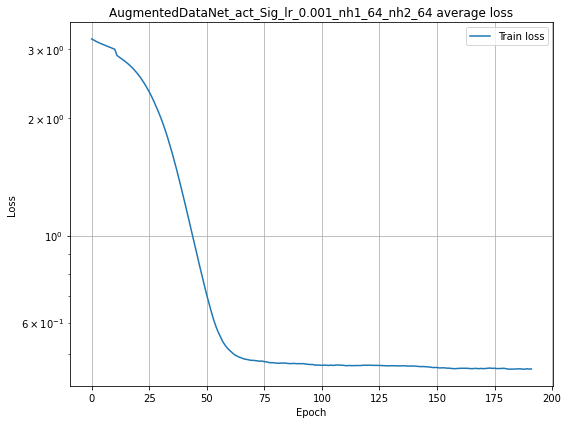

In [ ]:
name,net = nets[-1]
net_name=name
plt.figure(figsize=(8,6))
plt.title(net_name+' Average loss')
smoothing_window=21        
smoothed_train_loss=log_dataset[net_name].rolling(smoothing_window, min_periods=1,center=True).mean()
plt.semilogy(smoothed_train_loss, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Outputs and test evaluation

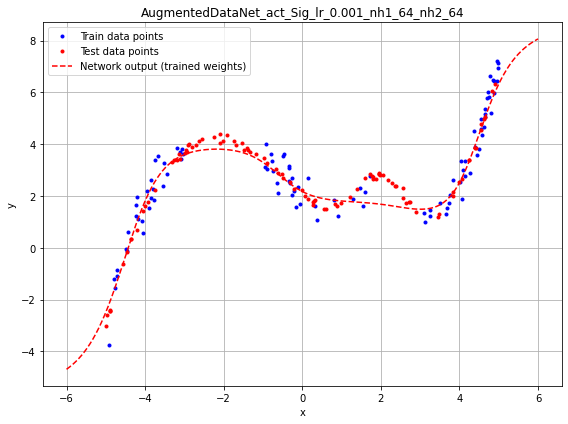

MSE Test Error:  0.21421601


In [ ]:
name,net = nets[-1]
x_highres = torch.linspace(-6, 6, 1000).unsqueeze(1).to(device)
test_tensor = torch.Tensor(test_df.iloc[:,0]).unsqueeze(1).to(device)

net_output = net.forward(x_highres)
net_prediction = net.forward(test_tensor).squeeze(1)

x_highres = x_highres.cpu().detach().numpy()
net_output = net_output.cpu().detach().numpy()
net_prediction = net_prediction.cpu().detach().numpy()

MSE=np.mean((np.array(test_df.iloc[:,1])-net_prediction)**2)

### Plot
plt.close('all')
plt.figure(figsize=(8,6))
plt.title(name)
plt.plot(train_df['input'], train_df['label'], color='b', ls='', marker='.', label='Train data points')
plt.plot(test_df['input'], test_df['label'], color='r', ls='', marker='.', label='Test data points')
plt.plot(x_highres, net_output, color='r', ls='--', label='Network output (trained weights)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
print('MSE Test Error: ',MSE)
test_errors.append([name,MSE])

#Classification task

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

## Data

In [ ]:
dataset = torchvision.datasets.MNIST('classification_dataset', train=True, download=True, transform=transforms.ToTensor())
train_dataset = dataset
test_dataset  = torchvision.datasets.MNIST('classification_dataset', train=False, download=True, transform=transforms.ToTensor())

### Examples

SAMPLE AT INDEX 2732
LABEL: 4


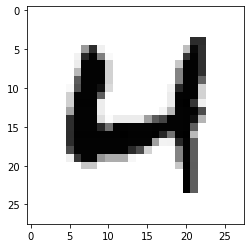

SAMPLE AT INDEX 43567
LABEL: 1


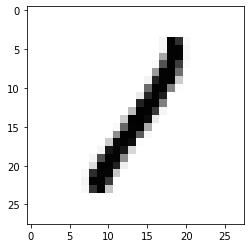

SAMPLE AT INDEX 42613
LABEL: 7


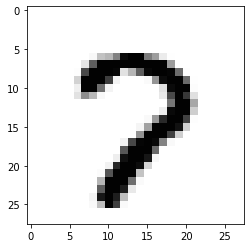

SAMPLE AT INDEX 52416
LABEL: 1


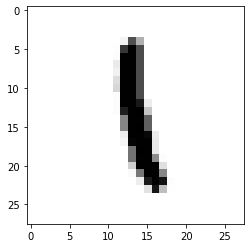

SAMPLE AT INDEX 45891
LABEL: 8


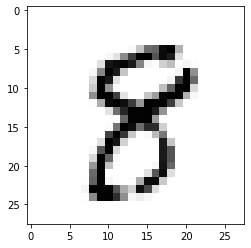

In [ ]:
for i in range(5):
  sample_index = np.random.randint(len(train_dataset))
  image = train_dataset[sample_index][0].squeeze(0)
  label = train_dataset[sample_index][1]

  fig = plt.figure(figsize=(4,4))
  plt.imshow(image, cmap='Greys')
  print(f"SAMPLE AT INDEX {sample_index}")
  print(f"LABEL: {label}")
  plt.show()

### Validation set division

In [ ]:
batch_size=50
train_dataset,valid_dataset=torch.utils.data.random_split(dataset, [50000,10000])
train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

##CNN Network Class

In [ ]:
class Classification_Net(nn.Module):
    def __init__(self, n_cnn_layers=2, act=nn.ReLU(), num_channels=32, n_fcl=200, n_classes=10, dropout_p=0.3):

        super().__init__()
        
        self.n_cnn_layers=n_cnn_layers
        
        multiplier_factor=28
        for i in range(self.n_cnn_layers):
          multiplier_factor = multiplier_factor//2
          in_channels=num_channels
          if i==0:  in_channels=1 
          vars(self)['_modules'][f'cnn{i+1}']=nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1)
          vars(self)['_modules'][f'act{i+1}']=act
          vars(self)['_modules'][f'maxpool{i+1}']=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(num_channels * (multiplier_factor**2), n_fcl) 
        self.fc2 = nn.Linear(n_fcl, n_classes)

        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
      #Convolutional
      out=x
      for i in range(self.n_cnn_layers):             
          out = (vars(self)['_modules'][f'cnn{i+1}'])(out)
          out = (vars(self)['_modules'][f'act{i+1}'])(out)
          out = (vars(self)['_modules'][f'maxpool{i+1}'])(out)

      #Flatten
      out = out.view(out.size(0), -1)
      
      #Dense
      out = self.fc1(out)
      out = self.dropout(out)
      out = self.fc2(out)
        
      return out

## Training

In [ ]:
#Parameters

loss_fn = nn.CrossEntropyLoss()
num_epochs_max = 100
opt_list=['SGD','SGDM','Adam']
lr_list=[1e-2, 1e-3]
weight_decay_list=[0, 5e-4]
dropout_p_list= [0, 0.3]
n_cnn_layers_list=[1,2,3]

log_dataset={}
nets=[]

for opt in opt_list:
  for lr in lr_list:  
    for weight_decay in weight_decay_list:
      for dropout_p in dropout_p_list:
        for n_cnn_layers in n_cnn_layers_list:
          # Initialize the network
          net = Classification_Net(n_cnn_layers=n_cnn_layers,dropout_p=dropout_p)
          net.to(device)
          # Define the optimizer
          optimizers={'SGD':optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay),
                      'SGDM':optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9),
                      'Adam':optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)}
          optimizer = optimizers[opt]

          net_name=f'Net_opt_{opt}_lr_{lr}_weightdecay_{weight_decay}_dropout_{dropout_p}_CNNlayers_{n_cnn_layers}'
          
          path='classification_models/'+net_name
          os.makedirs(path,exist_ok=True)

          # Load the network parameters and data
          time_training=0
          try:
            time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
            net_state_dict=torch.load(os.path.join(path,'net_params.torch'),map_location=torch.device(dev))
            net.load_state_dict(net_state_dict)
            try:
              log_dataset[net_name]
            except:
              log_dataset[net_name]=pd.read_csv(os.path.join(path,'net_train_err.csv'))
            log_dataset[net_name]['train_error']=pd.read_csv(os.path.join(path,f'net_train_err.csv'))
            log_dataset[net_name]['valid_error']=pd.read_csv(os.path.join(path,f'net_valid_err.csv'))
            train=False
          except:
            train=True

          print('----------------------------------')
          print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
          print('----------------------------------')

          ### TRAINING LOOP
          train_loss_log = []
          val_loss_log = []
          time_start = time.time()
          
          if train:
            for epoch_num in range(num_epochs_max):
              print(f'EPOCH {epoch_num}')

              ### TRAIN
              train_loss= []
              net.train() # Training mode (e.g. enable dropout)
              for sample_batched in tqdm(train_dataloader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Backpropagation
                net.zero_grad()
                loss.backward()

                # Update the weights
                optimizer.step()

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

              ### VALIDATION
              val_loss= []
              net.eval() # Evaluation mode (e.g. disable dropout)
              with torch.no_grad(): # Disable gradient tracking
                for sample_batched in tqdm(val_dataloader):
                  # Move data to device
                  x_batch = sample_batched[0].to(device)
                  label_batch = sample_batched[1].to(device)

                  # Forward pass
                  out = net(x_batch)

                  # Compute loss
                  loss = loss_fn(out, label_batch)

                  # Save val loss for this batch
                  loss_batch = loss.detach().cpu().numpy()
                  val_loss.append(loss_batch)

                # Save average losses
                train_loss = np.mean(train_loss)      
                val_loss = np.mean(val_loss)
                print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
                print(f"\tAVERAGE VAL LOSS: {val_loss}")
                train_loss_log.append(train_loss)
                val_loss_log.append(val_loss)

                #Early Stopping
                min_epochs=30
                window=10
                if epoch_num+1>=min_epochs and epoch_num+1>=window:
                  print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
                  if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
                    print('Early Stopping')
                    break

            time_end = time.time()
            time_training=time_end-time_start

            #Save data
            try:
              log_dataset[net_name]
            except:
              log_dataset[net_name]=pd.DataFrame()
            log_dataset[net_name]['train_error']=train_loss_log
            log_dataset[net_name]['valid_error']=val_loss_log
            log_dataset[net_name]['train_error'].to_csv(os.path.join(path,'net_train_err.csv'),index=False)
            log_dataset[net_name]['valid_error'].to_csv(os.path.join(path,'net_valid_err.csv'),index=False)
            net_state_dict = net.state_dict()
            torch.save(net_state_dict, os.path.join(path,'net_params.torch'))
            pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)

          nets.append((net_name,copy.deepcopy(net)))

----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_1 -- training time: 6.0 min 9.97 sec
----------------------------------
----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_2 -- training time: 4.0 min 23.43 sec
----------------------------------
----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_3 -- training time: 5.0 min 40.98 sec
----------------------------------
----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_1 -- training time: 7.0 min 28.01 sec
----------------------------------
----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_2 -- training time: 5.0 min 31.15 sec
----------------------------------
----------------------------------
Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_3 -- training time: 6.0 min 58.67 sec
----------------------------------
-----------------------

##Error history

In [ ]:
model_performances=[]

### SGD Optimizer, LR 0.01

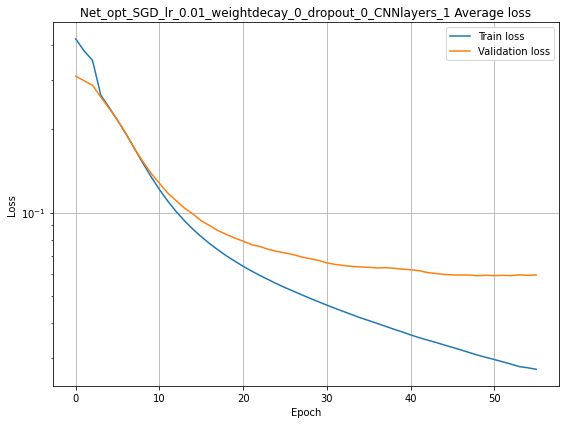

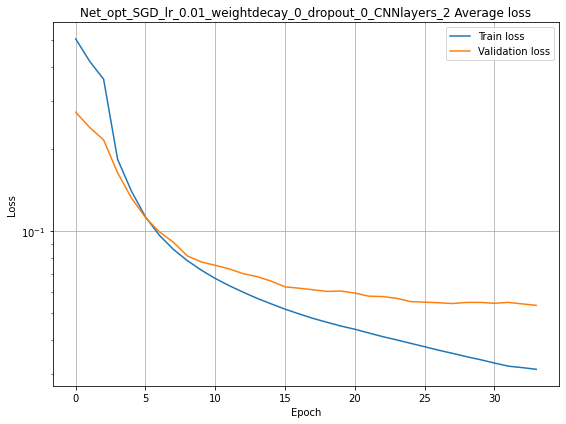

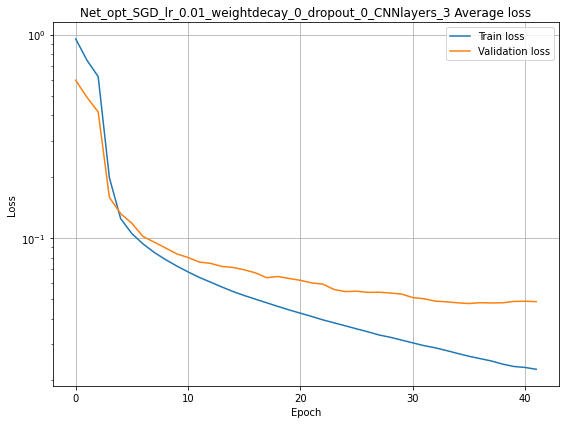

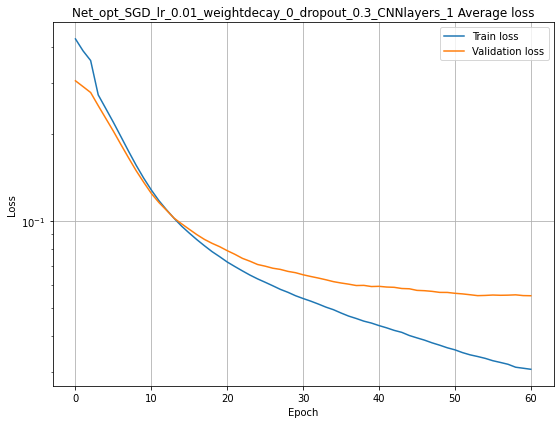

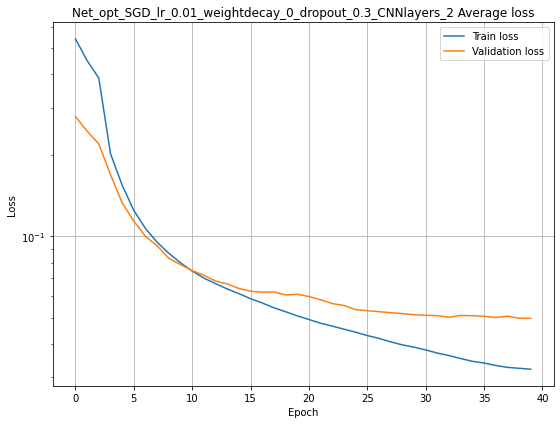

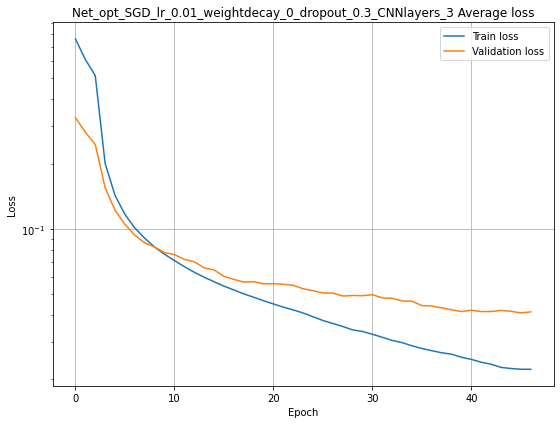

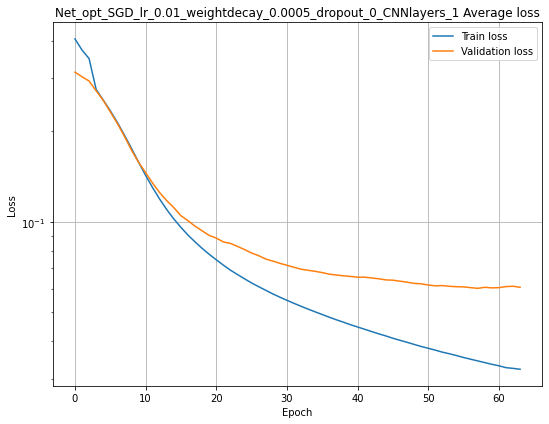

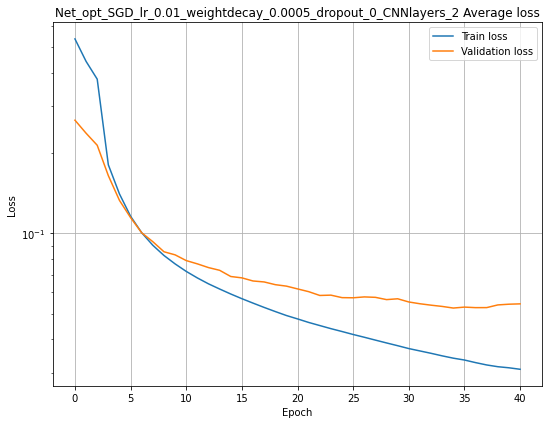

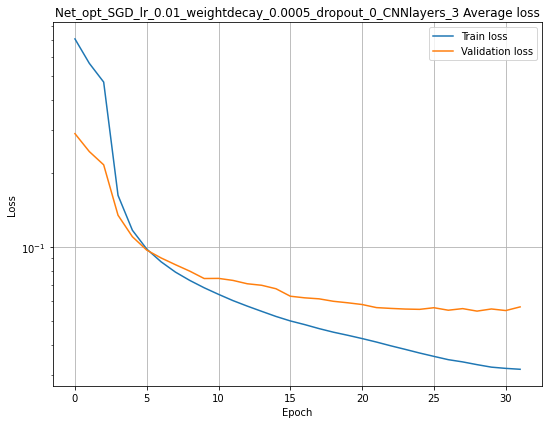

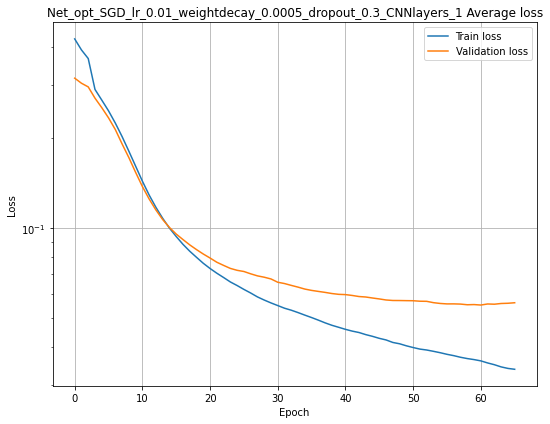

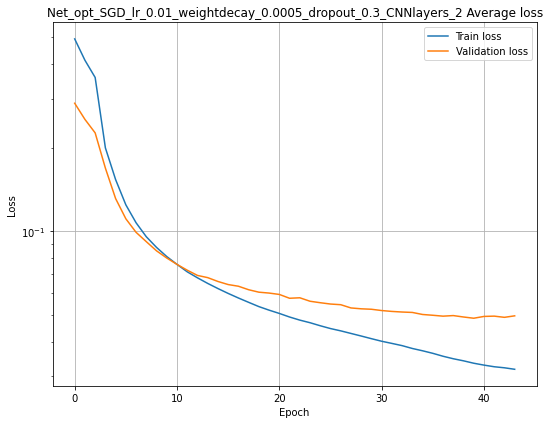

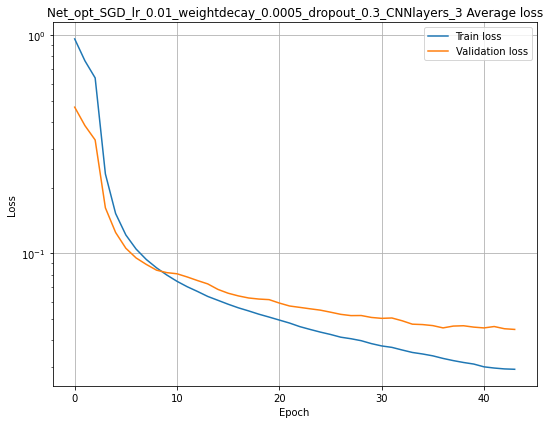

In [ ]:
for net_name,net in nets:
  if 'opt_SGD_' in net_name and 'lr_0.01_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


### SGD Optimizer, LR 0.001

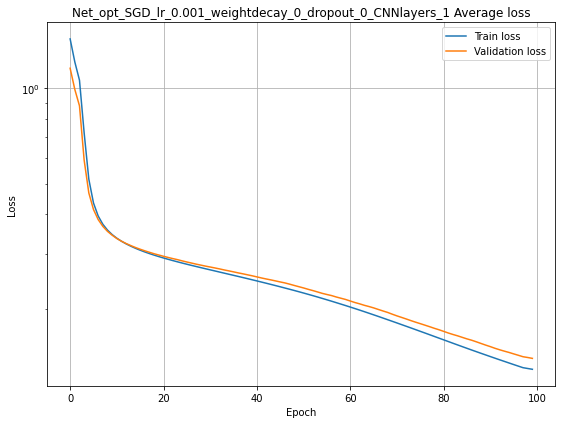

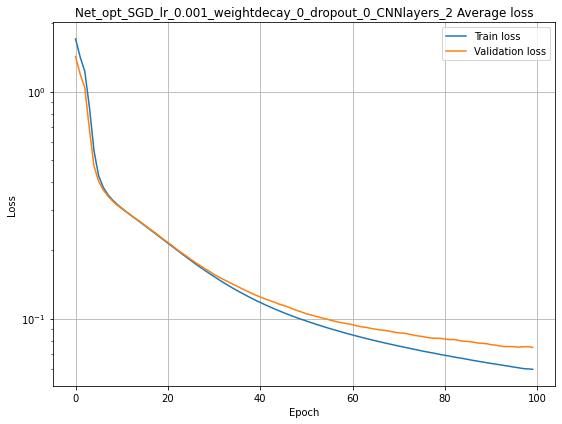

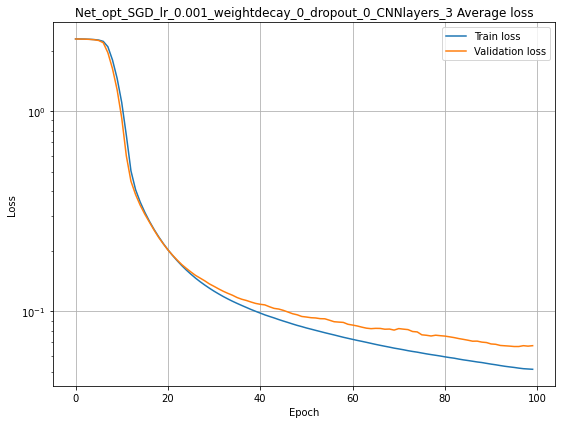

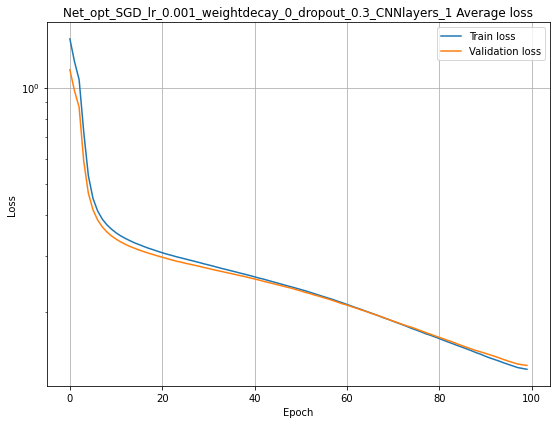

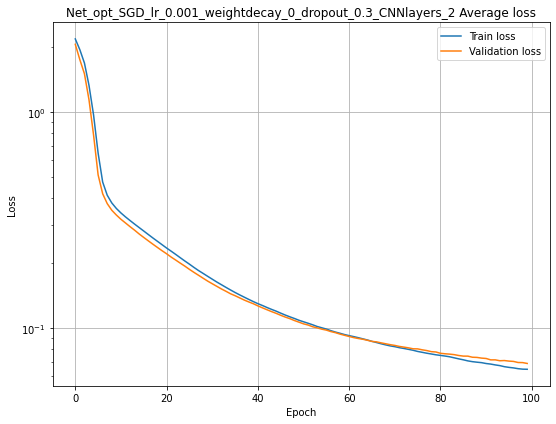

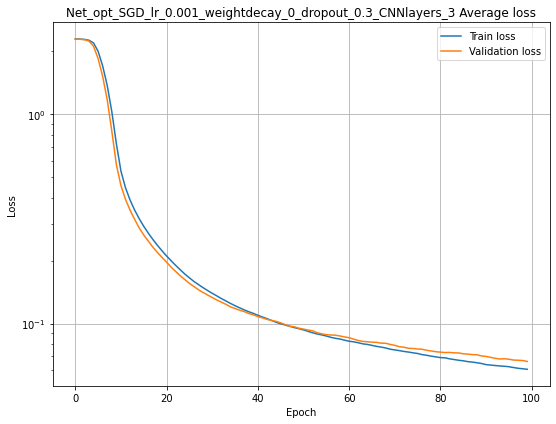

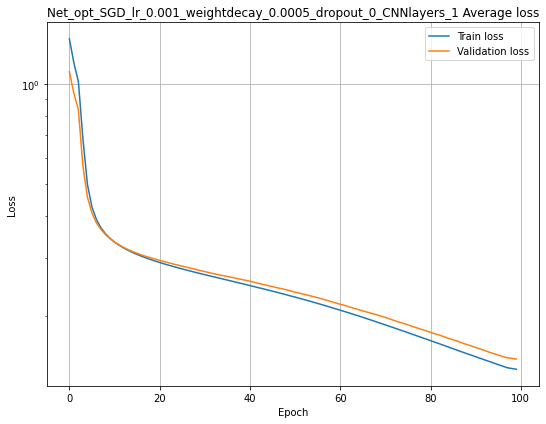

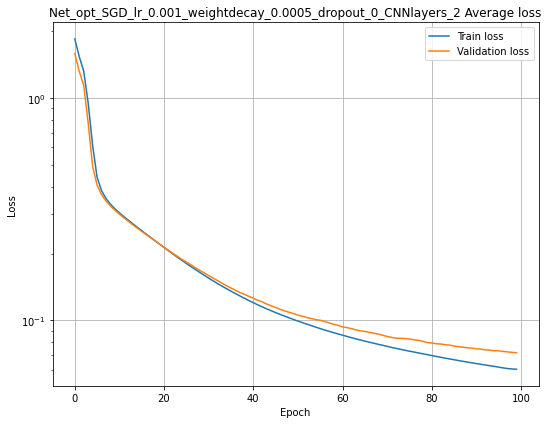

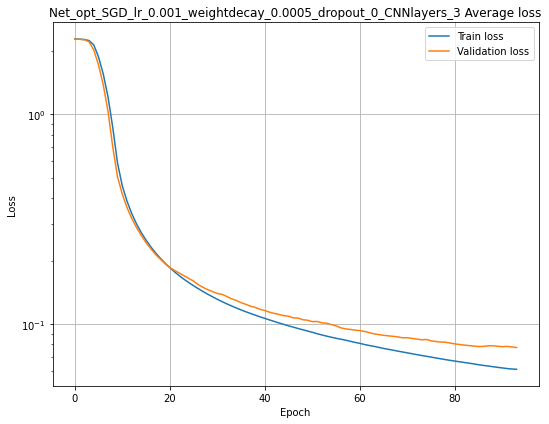

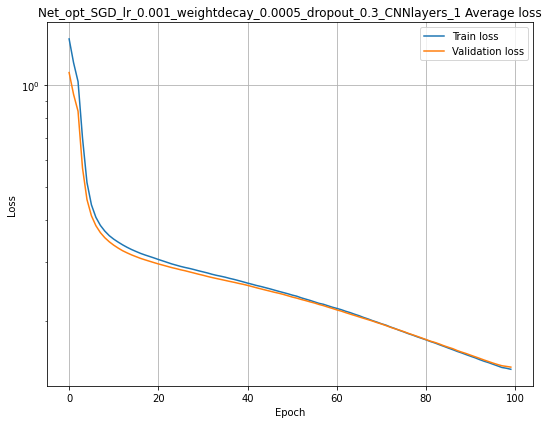

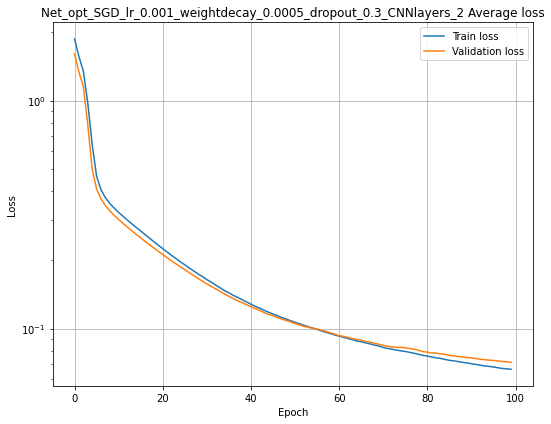

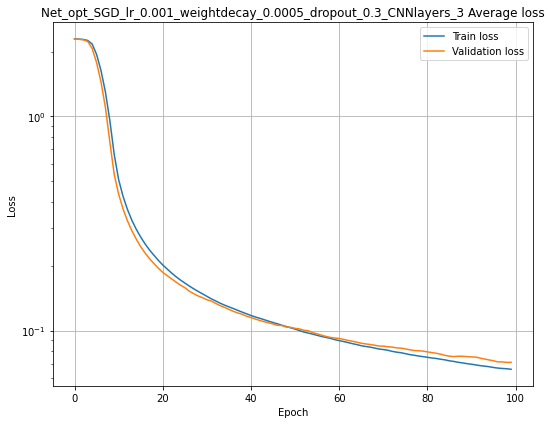

In [ ]:
for net_name,net in nets:
  if 'opt_SGD_' in net_name and 'lr_0.001_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


### SGDM Optimizer, LR 0.01

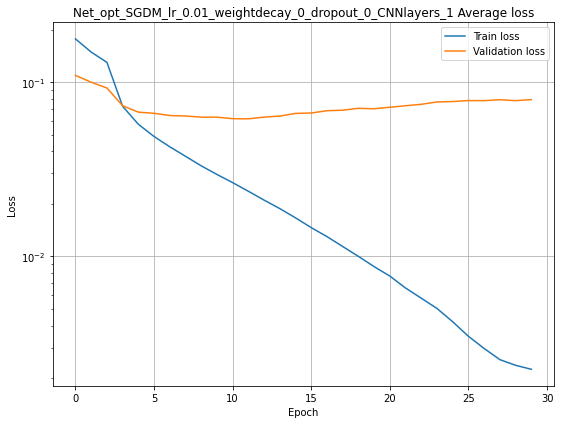

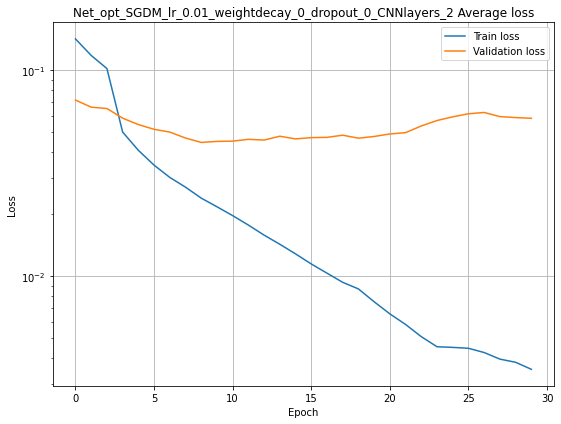

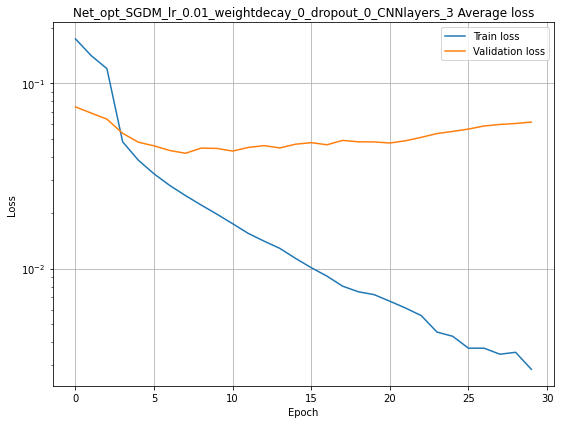

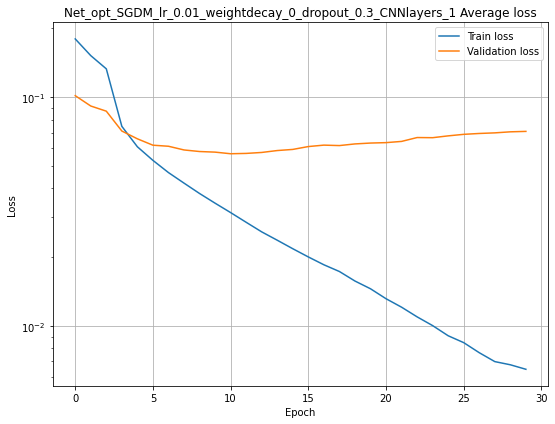

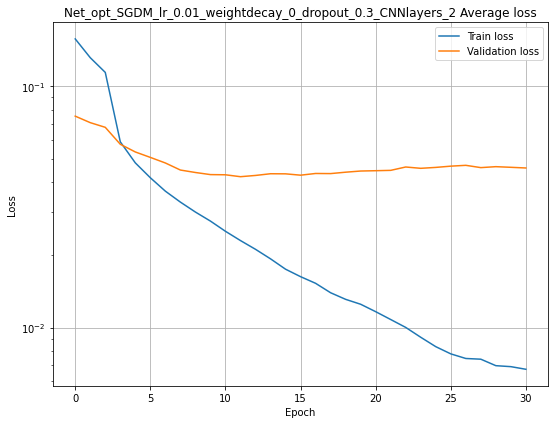

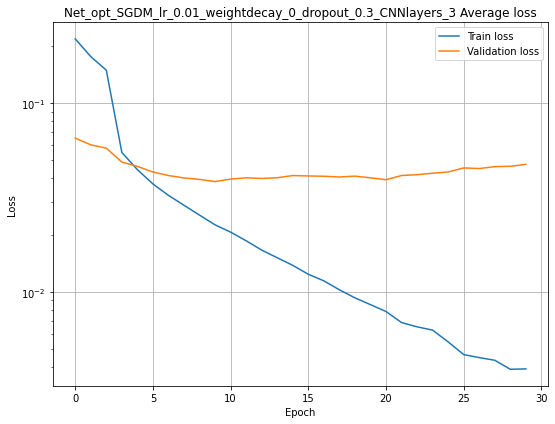

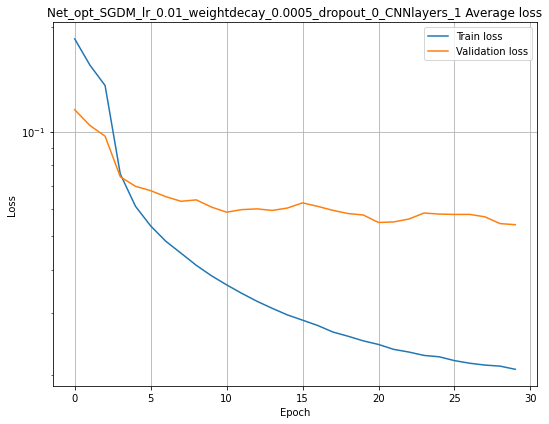

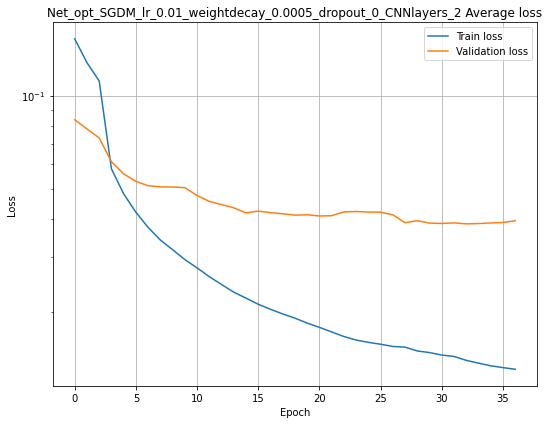

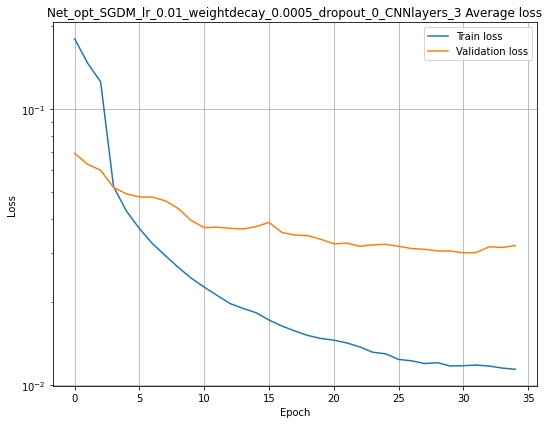

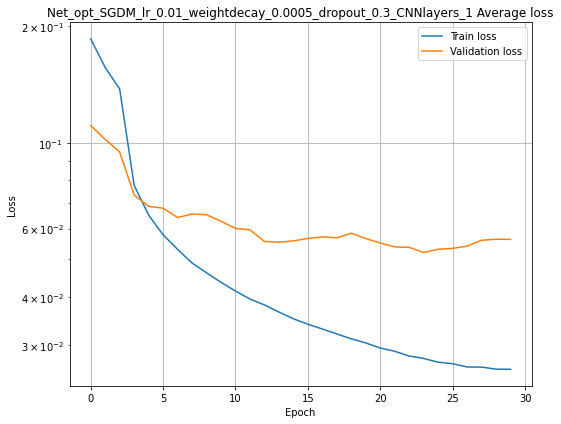

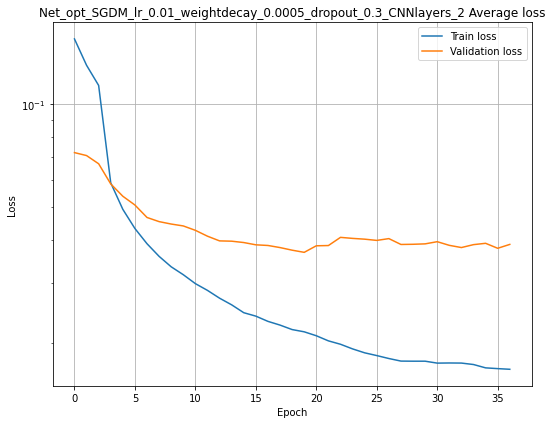

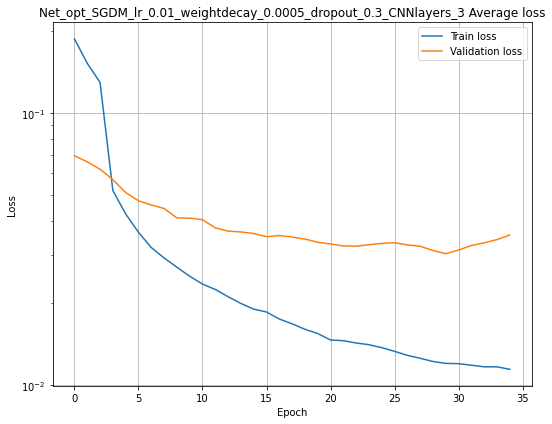

In [ ]:
for net_name,net in nets:
  if 'opt_SGDM_' in net_name and 'lr_0.01_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


### SGDM Optimizer, LR 0.001

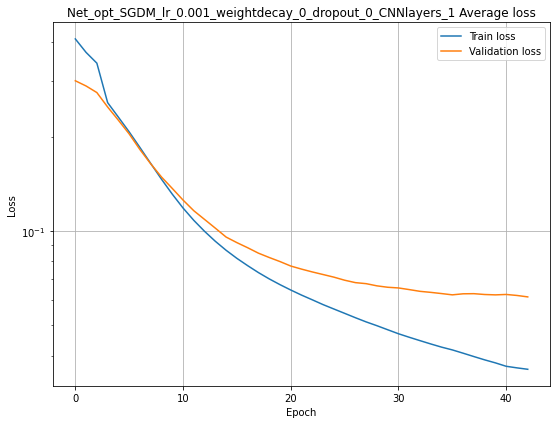

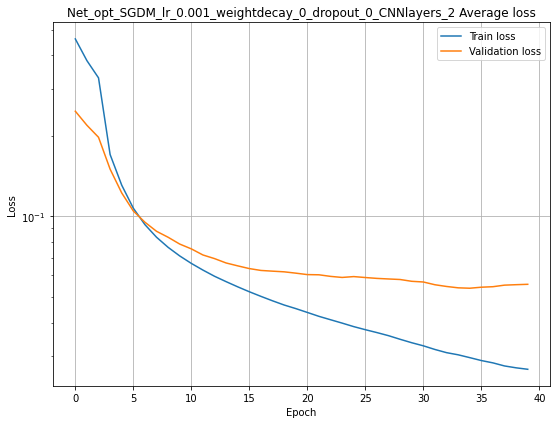

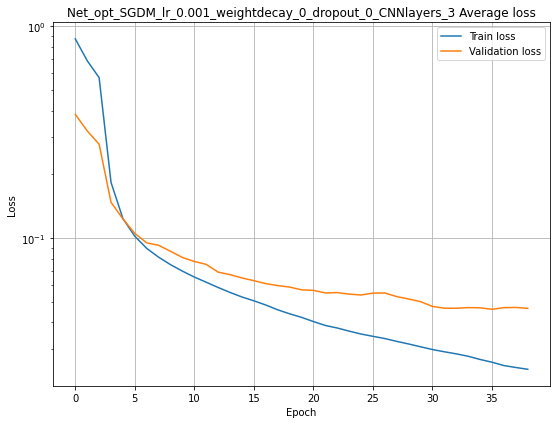

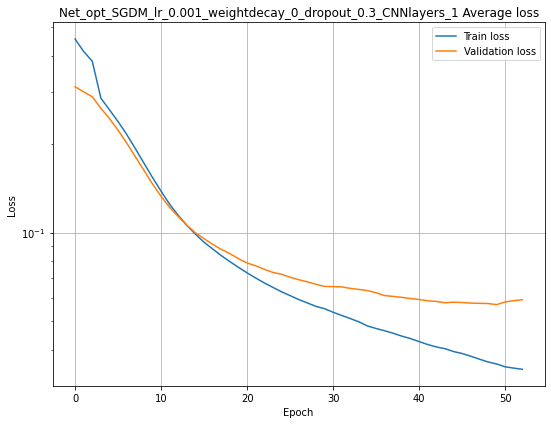

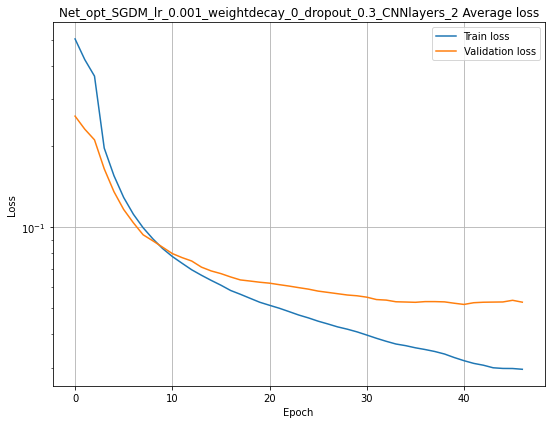

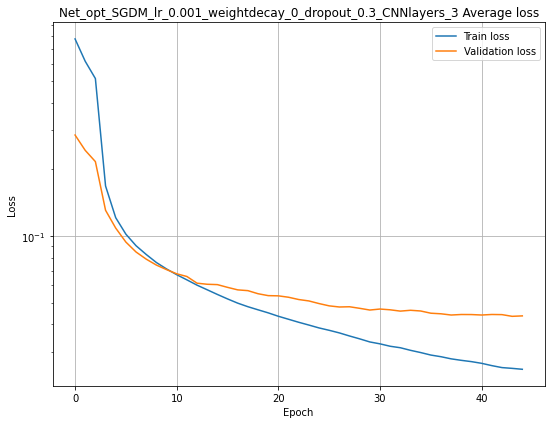

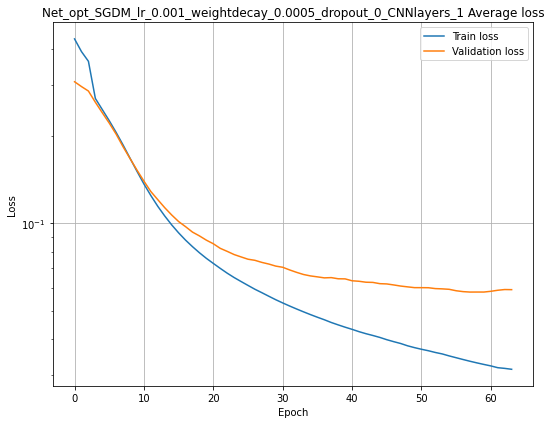

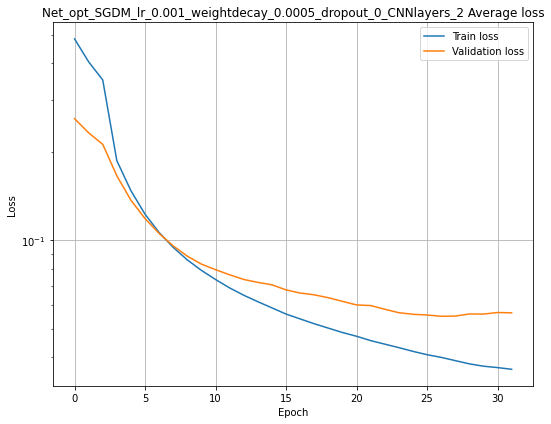

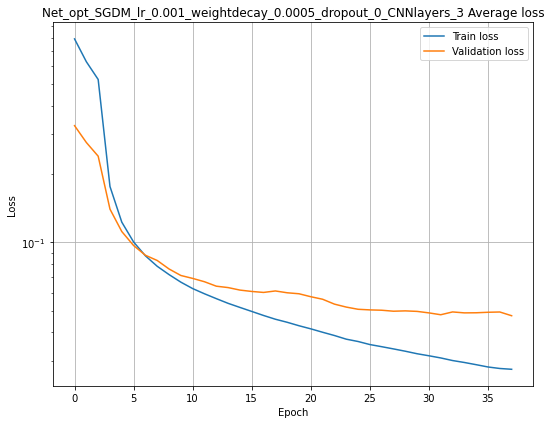

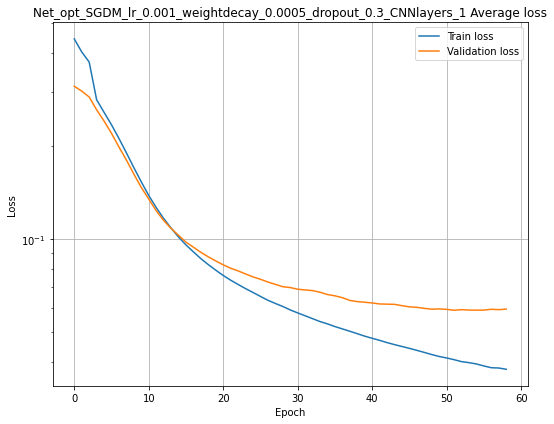

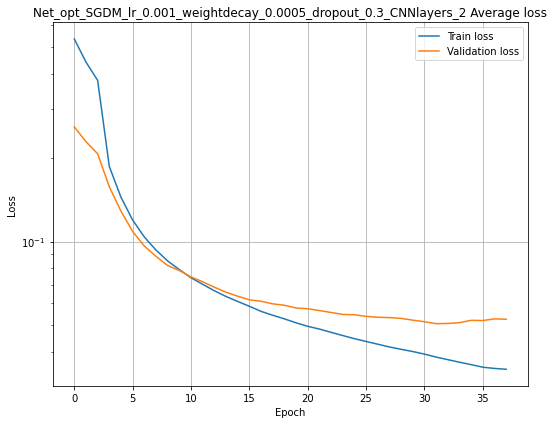

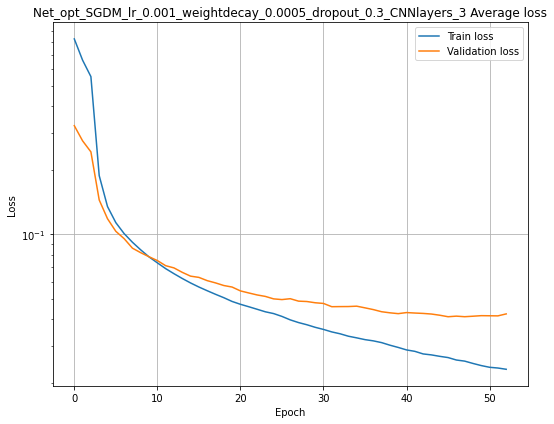

In [ ]:
for net_name,net in nets:
  if 'opt_SGDM_' in net_name and 'lr_0.001_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


### Adam Optimizer, LR 0.01

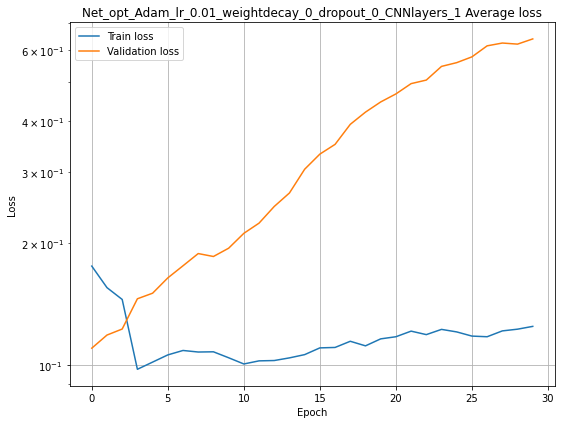

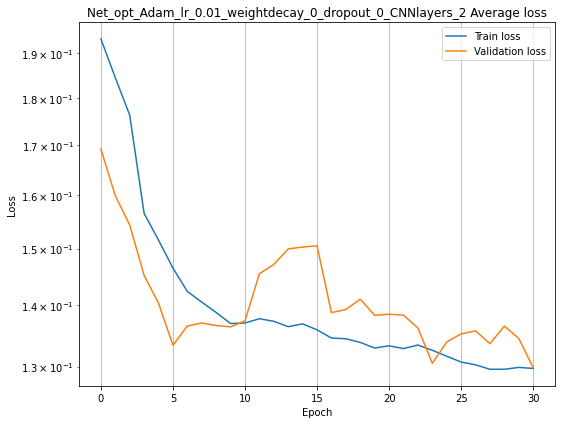

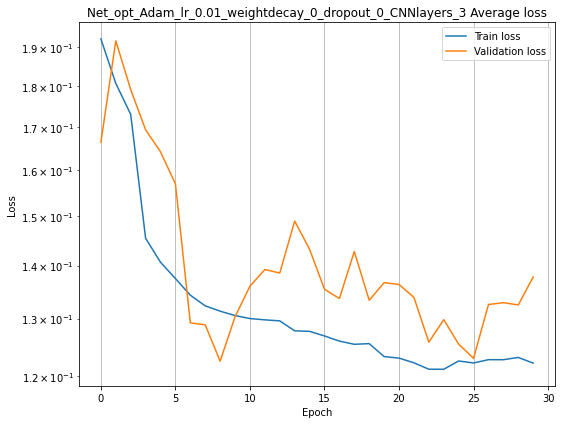

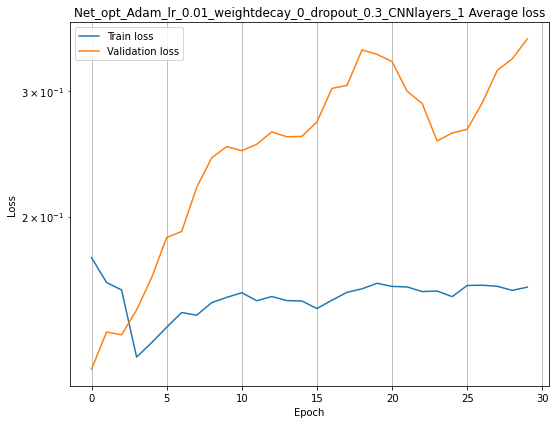

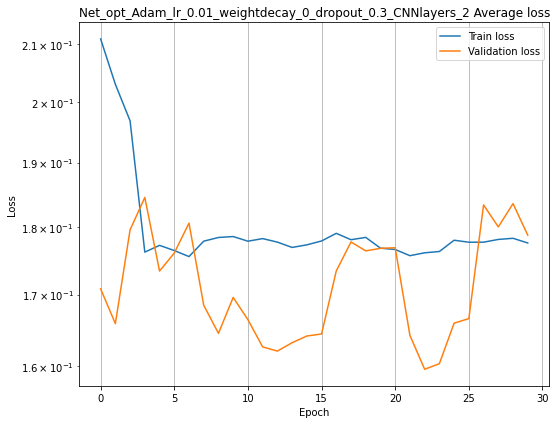

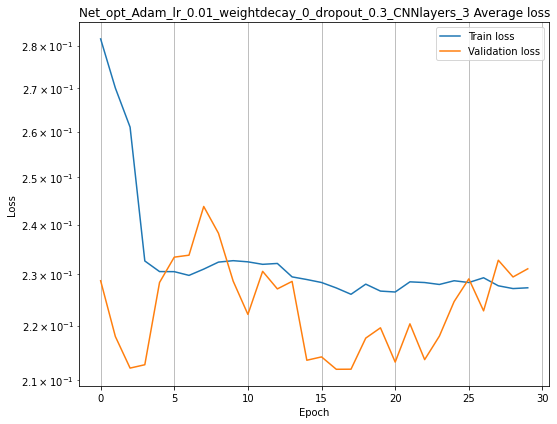

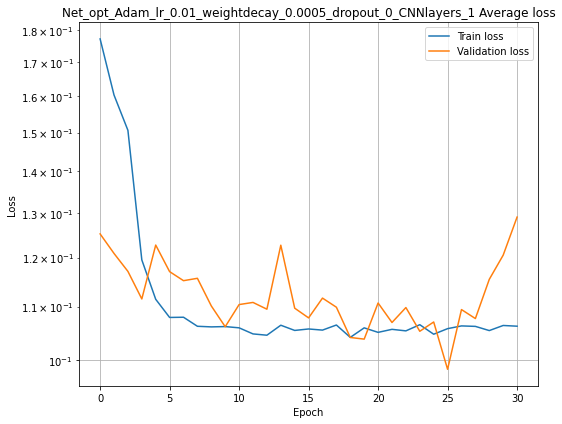

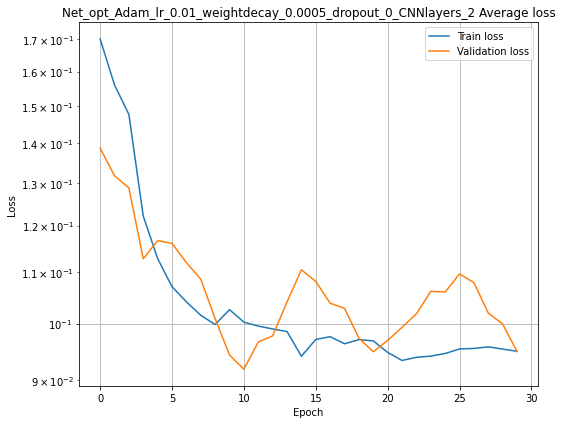

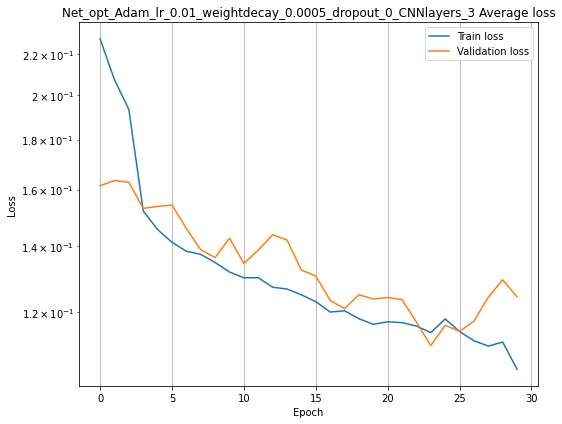

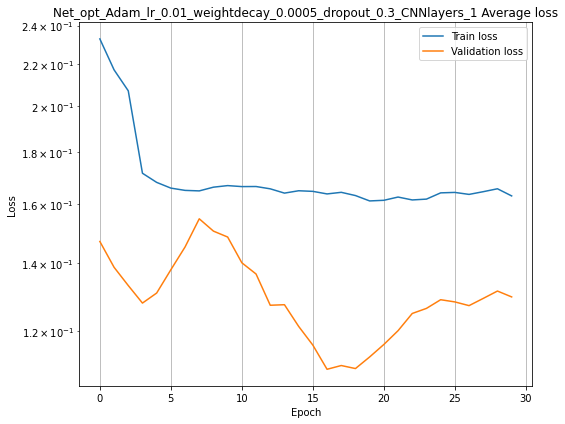

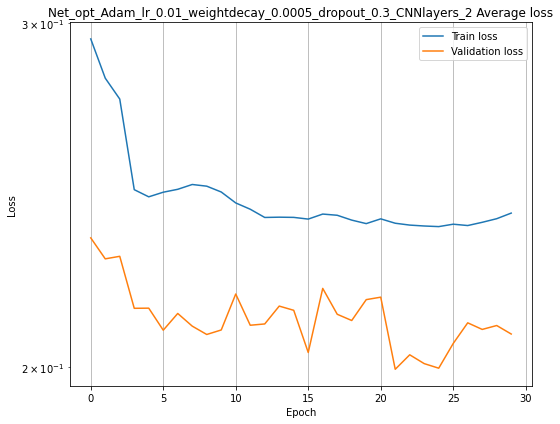

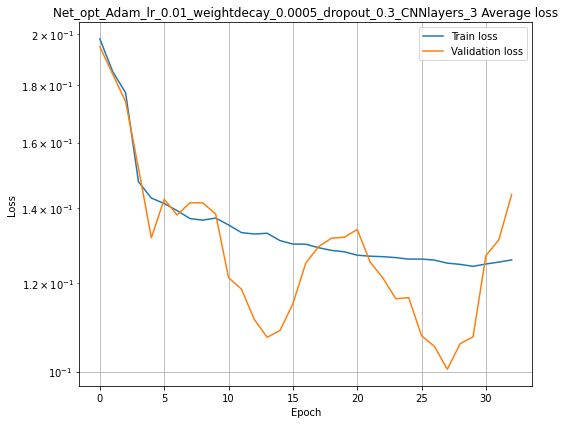

In [ ]:
for net_name,net in nets:
  if 'opt_Adam_' in net_name and 'lr_0.01_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


### Adam Optimizer, LR 0.001

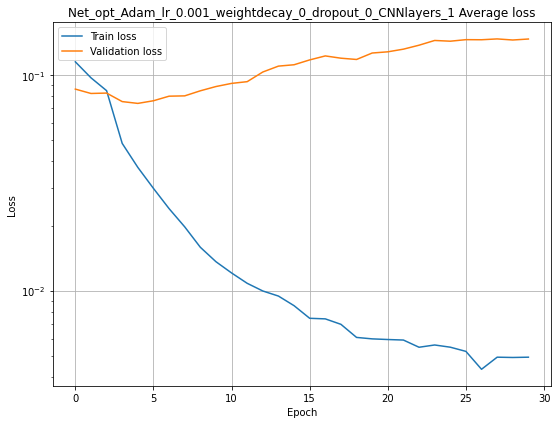

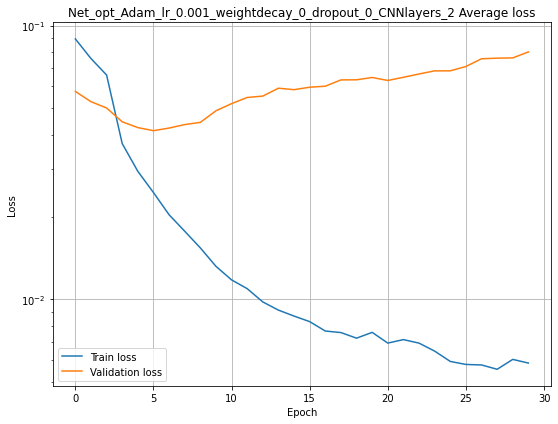

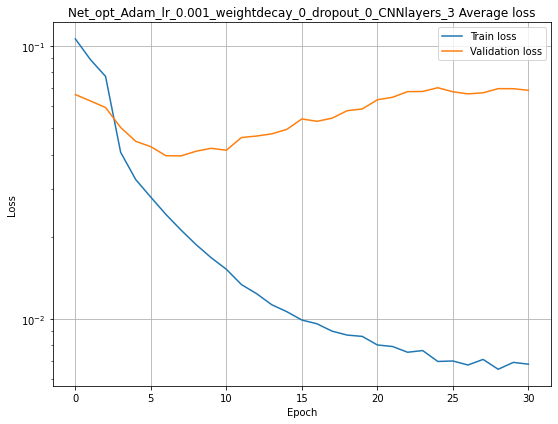

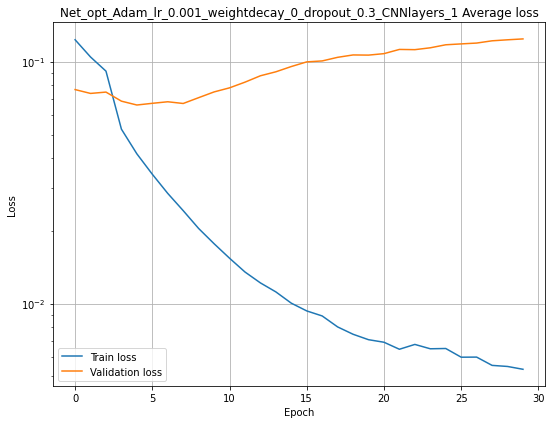

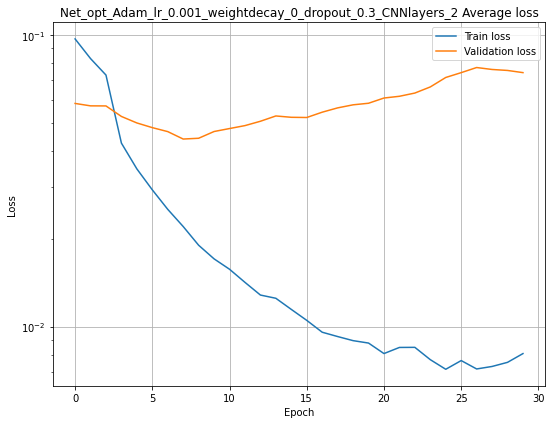

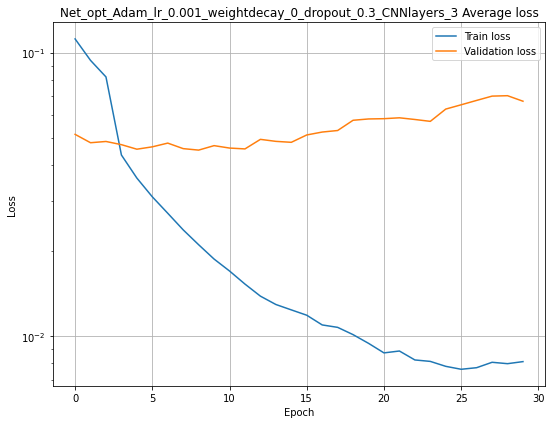

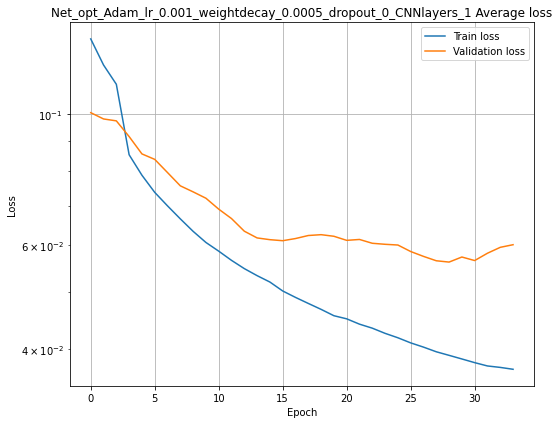

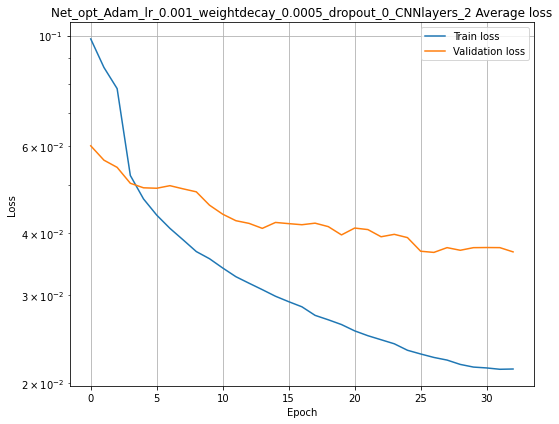

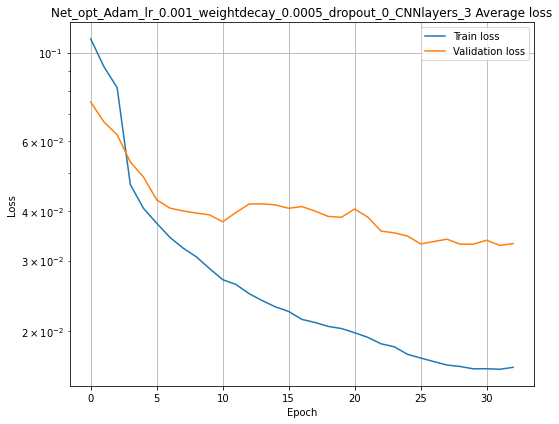

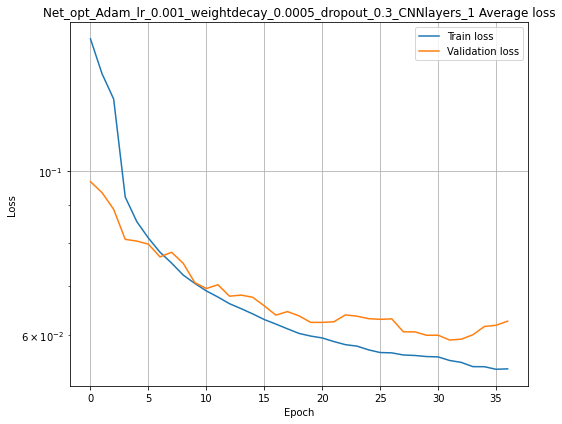

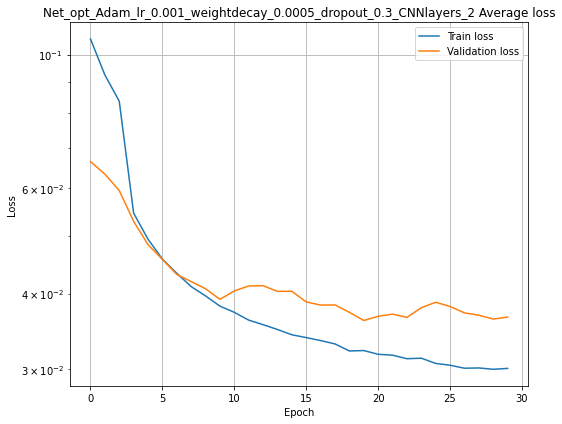

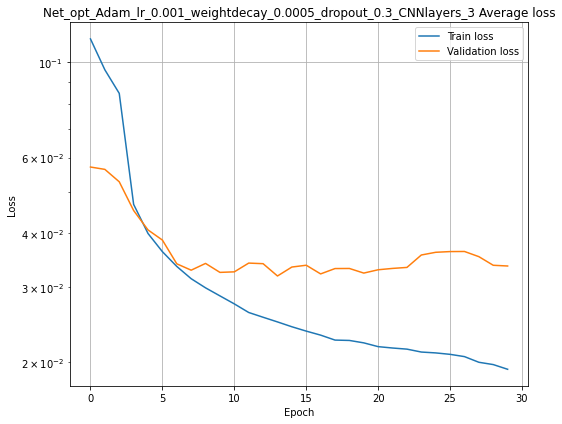

In [ ]:
for net_name,net in nets:
  if 'opt_Adam_' in net_name and 'lr_0.001_' in net_name:
    average_train_loss=log_dataset[net_name].iloc[:,0::2].mean(axis=1)
    average_valid_loss=log_dataset[net_name].iloc[:,1::2].mean(axis=1)
    smoothing_window=5       
    smoothed_train_loss=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    smoothed_valid_loss=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
    plt.figure(figsize=(8,6))
    plt.title(net_name+' Average loss')
    plt.semilogy(smoothed_train_loss, label='Train loss')
    plt.semilogy(smoothed_valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


##Test performances 

In [ ]:
for i,(net_name,net) in enumerate(nets):  
  x_test=test_dataset.data.unsqueeze(1).float().to(device)
  y_test=test_dataset.targets
  net.eval()
  with torch.no_grad():
      output = net(x_test)
  softmax = nn.Softmax(dim=1)(output)
  predictions = torch.argmax(softmax, dim=1)
  accuracy=accuracy_score(y_test, predictions.cpu())
  print(net_name)
  print(f"Test Accuracy:{accuracy}")
  print()
  model_performances[i].append(accuracy)

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_1
Test Accuracy:0.6673

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_2
Test Accuracy:0.9832

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CNNlayers_3
Test Accuracy:0.9867

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_1
Test Accuracy:0.6705

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_2
Test Accuracy:0.9842

Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_CNNlayers_3
Test Accuracy:0.991

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0_CNNlayers_1
Test Accuracy:0.6851

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0_CNNlayers_2
Test Accuracy:0.9741

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0_CNNlayers_3
Test Accuracy:0.9852

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0.3_CNNlayers_1
Test Accuracy:0.4493

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0.3_CNNlayers_2
Test Accuracy:0.9861

Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout_0.3_CNNlayers_3
Test Accuracy:0.989

Net_opt_SGD_lr_0.001_wei

In [ ]:
model_results=pd.DataFrame(model_performances,columns=['Model Name','Min Train Loss','Min Valid Loss','Test Accuracy'])

#Remove bad training configurations, see Error history
model_results=model_results[model_results['Model Name'].str.contains('opt_SGDM_lr_0.01_')==False]
model_results=model_results[model_results['Model Name'].str.contains('opt_Adam_lr_0.01_')==False]

#sort by validation loss
model_results_sorted=model_results.sort_values('Min Valid Loss')
display(model_results_sorted)

,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
71,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.019271,0.031795,0.9834
68,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.016013,0.032792,0.9886
70,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.029949,0.036106,0.7856
67,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.021304,0.036626,0.9529
62,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.006537,0.039562,0.9722
5,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.022302,0.040755,0.9910
47,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.023273,0.041084,0.9904
61,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.005549,0.041311,0.9325
41,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.025123,0.043534,0.9891
64,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0....,0.007149,0.043961,0.9458


## Hyperparameters comparison

### Optimizers comparison

In [ ]:
n_samples=6
print('SGD Optimizer')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('SGD_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('SGD with momentum Optimizer')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('SGDM_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('Adam Optimizer')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('Adam_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

SGD Optimizer


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
5,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.022302,0.040755,0.9910
11,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.029418,0.044810,0.9890
2,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CN...,0.022568,0.047517,0.9867
10,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.031799,0.048583,0.9861
4,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.032120,0.049640,0.9842
7,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.030905,0.052448,0.9741


Mean Validation Error:  0.04729244876652957 Mean Test Accuracy:  0.9851833333333332

SGD with momentum Optimizer


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
47,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.023273,0.041084,0.9904
41,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.025123,0.043534,0.9891
38,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0_...,0.024053,0.046148,0.9856
44,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.027525,0.047435,0.9861
46,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.034705,0.050642,0.9855
40,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.029569,0.051571,0.9805


Mean Validation Error:  0.04673572205420998 Mean Test Accuracy:  0.9862000000000001

Adam Optimizer


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
71,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.019271,0.031795,0.9834
68,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.016013,0.032792,0.9886
70,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.029949,0.036106,0.7856
67,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.021304,0.036626,0.9529
62,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.006537,0.039562,0.9722
61,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.005549,0.041311,0.9325


Mean Validation Error:  0.036365584439287585 Mean Test Accuracy:  0.9358666666666667



### L2 regularization and dropout comparison

In [ ]:
n_samples=6
print('No L2 regularization and no dropout')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('weightdecay_0_dropout_0_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('L2 regularization')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('weightdecay_0.0005_dropout_0_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('Dropout')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('weightdecay_0_dropout_0.3_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('L2 regularization and dropout')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('weightdecay_0.0005_dropout_0.3_')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

No L2 regularization and no dropout


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
62,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.006537,0.039562,0.9722
61,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.005549,0.041311,0.9325
38,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0_...,0.024053,0.046148,0.9856
2,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CN...,0.022568,0.047517,0.9867
1,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0_CN...,0.031235,0.053527,0.9832
37,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0_...,0.026723,0.053754,0.9831


Mean Validation Error:  0.0469701174232695 Mean Test Accuracy:  0.9738833333333333

L2 regularization


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
68,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.016013,0.032792,0.9886
67,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.021304,0.036626,0.9529
44,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.027525,0.047435,0.9861
7,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.030905,0.052448,0.9741
8,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.031701,0.054787,0.9852
43,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.036397,0.055120,0.9859


Mean Validation Error:  0.04653472845546074 Mean Test Accuracy:  0.9788

Dropout


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
5,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.022302,0.040755,0.9910
41,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.025123,0.043534,0.9891
64,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0....,0.007149,0.043961,0.9458
65,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0....,0.007620,0.045255,0.9326
4,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.032120,0.049640,0.9842
40,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.029569,0.051571,0.9805


Mean Validation Error:  0.04578608233067725 Mean Test Accuracy:  0.9705333333333334

L2 regularization and dropout


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
71,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.019271,0.031795,0.9834
70,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.029949,0.036106,0.7856
47,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.023273,0.041084,0.9904
11,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.029418,0.044810,0.9890
10,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.031799,0.048583,0.9861
46,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.034705,0.050642,0.9855


Mean Validation Error:  0.042170212583409424 Mean Test Accuracy:  0.9533333333333335



### CNN layers parameter comparison

In [ ]:
n_samples=6
print('1 CNN layers best models')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('CNNlayers_1')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('2 CNN layers best models')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('CNNlayers_2')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

print('3 CNN layers best models')
temp=model_results_sorted[model_results_sorted['Model Name'].str.contains('CNNlayers_3')].head(n_samples)
display(temp)
print('Mean Validation Error: ', temp['Min Valid Loss'].mean(), 'Mean Test Accuracy: ',temp['Test Accuracy'].mean(),end='\n\n')

1 CNN layers best models


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
3,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.030672,0.055123,0.6705
9,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.033745,0.055260,0.4493
66,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.036973,0.056169,0.2908
39,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.034263,0.056856,0.5246
42,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.031340,0.057939,0.4405
45,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.037902,0.058854,0.6213


Mean Validation Error:  0.056700347736477856 Mean Test Accuracy:  0.4995

2 CNN layers best models


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
70,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.029949,0.036106,0.7856
67,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.021304,0.036626,0.9529
61,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.005549,0.041311,0.9325
64,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0....,0.007149,0.043961,0.9458
10,Net_opt_SGD_lr_0.01_weightdecay_0.0005_dropout...,0.031799,0.048583,0.9861
4,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.032120,0.049640,0.9842


Mean Validation Error:  0.04270477179023954 Mean Test Accuracy:  0.9311833333333333

3 CNN layers best models


,Model Name,Min Train Loss,Min Valid Loss,Test Accuracy
71,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.019271,0.031795,0.9834
68,Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropo...,0.016013,0.032792,0.9886
62,Net_opt_Adam_lr_0.001_weightdecay_0_dropout_0_...,0.006537,0.039562,0.9722
5,Net_opt_SGD_lr_0.01_weightdecay_0_dropout_0.3_...,0.022302,0.040755,0.9910
47,Net_opt_SGDM_lr_0.001_weightdecay_0.0005_dropo...,0.023273,0.041084,0.9904
41,Net_opt_SGDM_lr_0.001_weightdecay_0_dropout_0....,0.025123,0.043534,0.9891


Mean Validation Error:  0.03825379104043047 Mean Test Accuracy:  0.9857833333333333



## Best network

In [ ]:
best_net_name,best_net=nets[model_results_sorted.index[0]]
x_test=test_dataset.data.unsqueeze(1).float().to(device)
y_test=test_dataset.targets
best_net.eval()
with torch.no_grad():
    output = best_net(x_test)
softmax = nn.Softmax(dim=1)(output)
predictions = torch.argmax(softmax, dim=1).cpu()
accuracy=accuracy_score(y_test, predictions)
print(best_net_name)
print('Test accuracy:', accuracy)

Net_opt_Adam_lr_0.001_weightdecay_0.0005_dropout_0.3_CNNlayers_3
Test accuracy: 0.9834


### Confusion matrix

[[ 967    0    3    0    0    0    1    2    7    0]
 [   0 1122    2    0    1    0    1    6    3    0]
 [   1    0 1026    0    0    0    0    4    1    0]
 [   0    0    5 1001    0    2    0    2    0    0]
 [   0    0    1    0  962    0    1    4   13    1]
 [   0    0    0    4    1  885    1    1    0    0]
 [   3    1    1    0    1    2  946    0    4    0]
 [   0    0    6    0    0    0    0 1019    1    2]
 [   1    0    3    0    0    1    0    1  967    1]
 [   1    0    0    0   13    7    0   12   37  939]]


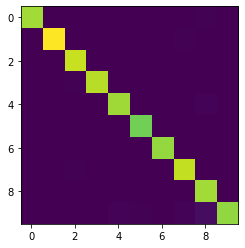

In [ ]:
c_matrix=confusion_matrix(y_test,predictions)
print(c_matrix)
plt.imshow(c_matrix)
plt.show()

### Prediction examples

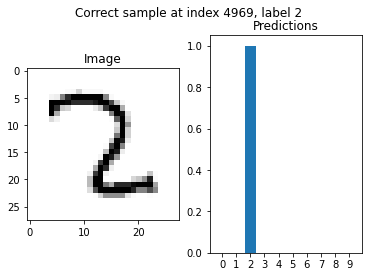

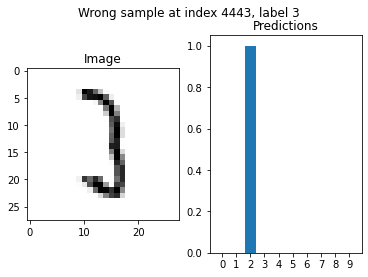

In [ ]:
correct_indexes=np.where(y_test==predictions)[0]
wrong_indexes=np.where(y_test!=predictions)[0]
correct_sample=np.random.choice(correct_indexes)
wrong_sample=np.random.choice(wrong_indexes)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Correct sample at index {correct_sample}, label {y_test[correct_sample]}')
ax1.set_title('Image')
ax1.imshow(x_test[correct_sample].squeeze(0).squeeze(1).cpu(), cmap='Greys')
ax2.set_title('Predictions')
ax2.bar(range(10),softmax[correct_sample].squeeze(0).cpu())
ax2.set_xticks(range(10))
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Wrong sample at index {wrong_sample}, label {y_test[wrong_sample]}')
ax1.set_title('Image')
ax1.imshow(x_test[wrong_sample].squeeze(0).squeeze(0).cpu(), cmap='Greys')
ax2.set_title('Predictions')
ax2.bar(range(10),softmax[wrong_sample].squeeze(0).cpu())
ax2.set_xticks(range(10))
plt.show()

### Filters

Convolutional layers
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) --> Shape: torch.Size([32, 1, 3, 3])
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) --> Shape: torch.Size([32, 32, 3, 3])
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) --> Shape: torch.Size([32, 32, 3, 3])
Last layer filters


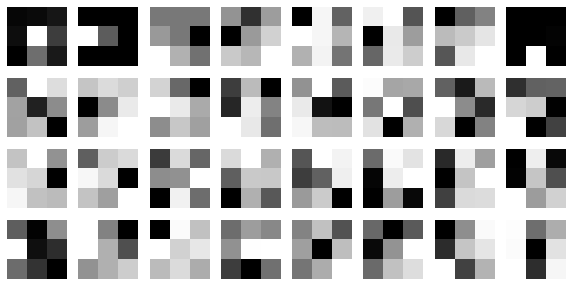

In [ ]:
print('Convolutional layers')
model_weights = [] 
conv_layers = []
for element in list(best_net.children()):
  if type(element) == nn.Conv2d:
    model_weights.append(element.weight)
    conv_layers.append(element)
for weight, conv in zip(model_weights, conv_layers):
  print(f"{conv} --> Shape: {weight.shape}")

print('Last layer filters')
plt.figure(figsize=(10, 5))
for i, filter in enumerate(model_weights[-1]):
  plt.subplot(4, 8, i+1)
  plt.imshow(filter[0, :, :].detach().cpu(), cmap='Greys')
  plt.axis('off')
plt.show()

### Feature maps

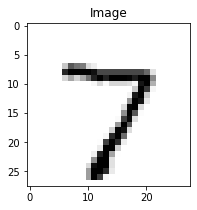

Layer 0 feature maps


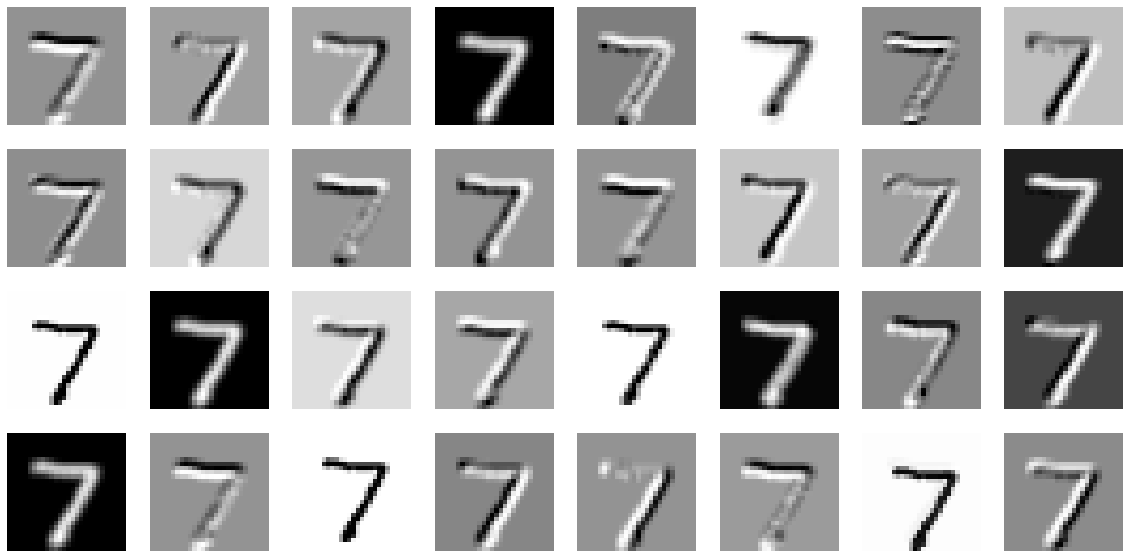

Layer 1 feature maps


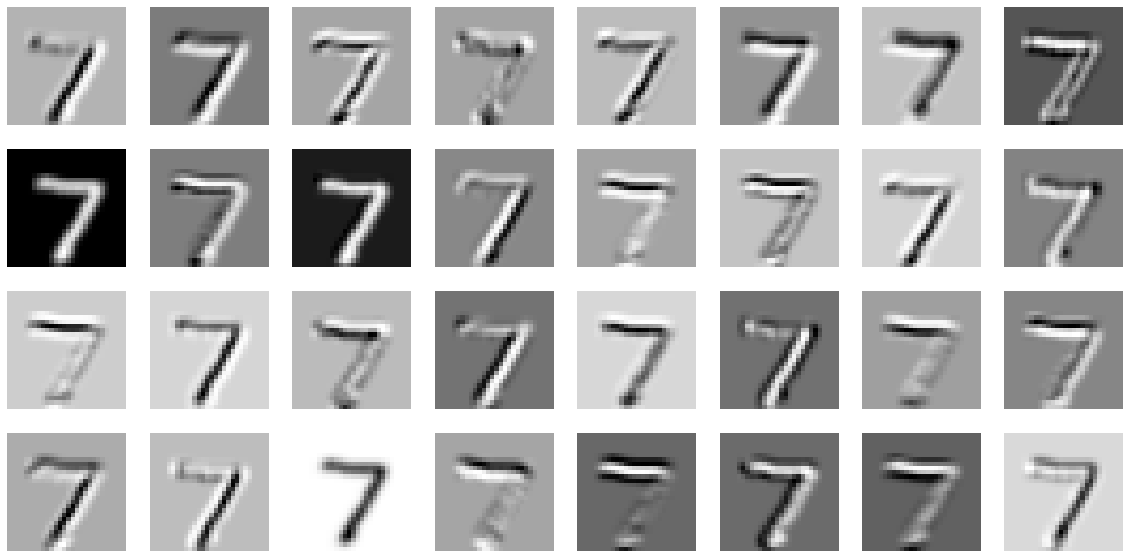

Layer 2 feature maps


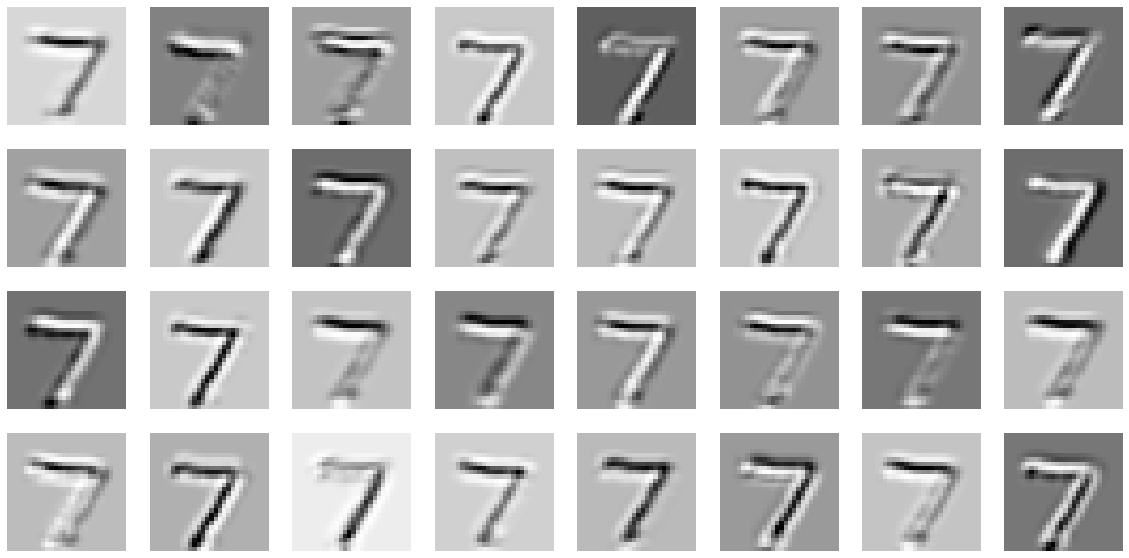

In [ ]:
image=x_test[0].unsqueeze(0)
fig = plt.figure(figsize=(3,3))
plt.title('Image')
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='Greys')
plt.show()


results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
  results.append(conv_layers[i](results[-1]))
outputs = results

for num_layer,feature_maps in enumerate(outputs):
  print(f"Layer {num_layer} feature maps")
  plt.figure(figsize=(20, 10))
  feature_maps = feature_maps[0, :, :, :].data
  for i, feature_map in enumerate(feature_maps):
    plt.subplot(4, 8, i + 1)
    plt.imshow(feature_map.cpu(), cmap='Greys')
    plt.axis("off")
  plt.show()